In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil


# 1.Data Cleaning and Feature Engineering

## 1.1 Importing all the modules used in the project

In [3]:
import pandas as pd
import ast
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import numpy as np

* https://ucladatares.medium.com/the-success-of-movies-at-the-oscars-box-office-and-reviews-e33e5059ea40
* https://www.stat.cmu.edu/capstoneresearch/fall2022/315files_f22/team24.html

## 1.2. Import Dataset

In [4]:
df = pd.read_csv("/content/drive/MyDrive/Khai thác dữ liệu và ứng dụng - T5/Final_dataset/MoviesIndustry/movies.csv")

In [5]:
df.describe()

year        score         votes        budget         gross  \
count  7668.000000  7665.000000  7.665000e+03  5.497000e+03  7.479000e+03   
mean   2000.405451     6.390411  8.810850e+04  3.558988e+07  7.850054e+07   
std      11.153508     0.968842  1.633238e+05  4.145730e+07  1.657251e+08   
min    1980.000000     1.900000  7.000000e+00  3.000000e+03  3.090000e+02   
25%    1991.000000     5.800000  9.100000e+03  1.000000e+07  4.532056e+06   
50%    2000.000000     6.500000  3.300000e+04  2.050000e+07  2.020576e+07   
75%    2010.000000     7.100000  9.300000e+04  4.500000e+07  7.601669e+07   
max    2020.000000     9.300000  2.400000e+06  3.560000e+08  2.847246e+09   

           runtime  
count  7664.000000  
mean    107.261613  
std      18.581247  
min      55.000000  
25%      95.000000  
50%     104.000000  
75%     116.000000  
max     366.000000

In [6]:
movies_metadata_df = df.copy()

In [7]:
movies_metadata_df.shape

(7668, 15)

## 1.3. Classic data cleaning steps

**Xóa missing values**

In [8]:
missing_value_percent = movies_metadata_df.isnull().sum() / len(movies_metadata_df) * 100

# Print the results
print(missing_value_percent)

name         0.000000
rating       1.004173
genre        0.000000
year         0.000000
released     0.026082
score        0.039124
votes        0.039124
director     0.000000
writer       0.039124
star         0.013041
country      0.039124
budget      28.312467
gross        2.464789
company      0.221701
runtime      0.052165
dtype: float64


In [9]:
movies_metadata_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7668 entries, 0 to 7667
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   name      7668 non-null   object 
 1   rating    7591 non-null   object 
 2   genre     7668 non-null   object 
 3   year      7668 non-null   int64  
 4   released  7666 non-null   object 
 5   score     7665 non-null   float64
 6   votes     7665 non-null   float64
 7   director  7668 non-null   object 
 8   writer    7665 non-null   object 
 9   star      7667 non-null   object 
 10  country   7665 non-null   object 
 11  budget    5497 non-null   float64
 12  gross     7479 non-null   float64
 13  company   7651 non-null   object 
 14  runtime   7664 non-null   float64
dtypes: float64(5), int64(1), object(9)
memory usage: 898.7+ KB


Xử lí lại việc tách date ra theo tháng

In [10]:
# Extracting 'month' from 'released'
movies_metadata_df['month'] = movies_metadata_df['released'].apply(lambda x: x.split()[0] if isinstance(x, str) else np.nan)
valid_months = ['June', 'July', 'May', 'December', 'October', 'September',
       'February', 'April', 'August', 'March', 'November', 'January']

movies_metadata_df['month'] = movies_metadata_df['released'].apply(lambda x: x.split()[0] if isinstance(x, str) and x.split()[0] in valid_months else np.nan)
# movies_metadata_df = movies_metadata_df.drop(columns = ['released'])

# Handling missing values by filling them with appropriate placeholders or zeros
movies_metadata_df["genre"].fillna('Unknown', inplace=True)
movies_metadata_df['country'].fillna('Unknown', inplace=True)
movies_metadata_df['name'].fillna('Unknown', inplace=True)
movies_metadata_df['rating'].fillna('Unknown', inplace=True)
movies_metadata_df['writer'].fillna('Unknown', inplace=True)
movies_metadata_df['star'].fillna('Unknown', inplace=True)
movies_metadata_df['company'].fillna('Unknown', inplace=True)
movies_metadata_df['month'].fillna('Unknown', inplace = True)
movies_metadata_df[['score','votes','budget', 'gross','runtime', 'year']] = movies_metadata_df[['score','votes','budget', 'gross', 'runtime', 'year']].fillna(0)

# Previewing the cleaned dataset
movies_metadata_df.head()

name rating      genre  year  \
0                                     The Shining      R      Drama  1980   
1                                 The Blue Lagoon      R  Adventure  1980   
2  Star Wars: Episode V - The Empire Strikes Back     PG     Action  1980   
3                                       Airplane!     PG     Comedy  1980   
4                                      Caddyshack      R     Comedy  1980   

                        released  score      votes         director  \
0  June 13, 1980 (United States)    8.4   927000.0  Stanley Kubrick   
1   July 2, 1980 (United States)    5.8    65000.0   Randal Kleiser   
2  June 20, 1980 (United States)    8.7  1200000.0   Irvin Kershner   
3   July 2, 1980 (United States)    7.7   221000.0     Jim Abrahams   
4  July 25, 1980 (United States)    7.3   108000.0     Harold Ramis   

                    writer            star         country      budget  \
0             Stephen King  Jack Nicholson  United Kingdom  19000000.0   
1  Henry De Vere Stacpoole  Brooke Shields   United States   4500000.0   
2           Leigh Brackett     Mark Hamill   United States  18000000.0   
3             Jim Abrahams     Robert Hays   United States   3500000.0   
4       Brian Doyle-Murray     Chevy Chase   United States   6000000.0   

         gross             company  runtime month  
0   46998772.0        Warner Bros.    146.0  June  
1   58853106.0   Columbia Pictures    104.0  July  
2  538375067.0           Lucasfilm    124.0  June  
3   83453539.0  Paramount Pictures     88.0  July  
4   39846344.0      Orion Pictures     98.0  July

**Delete duplicate**

In [11]:
num_duplicates = movies_metadata_df.duplicated().sum()

# Calculate the percentage of duplicates
percent_duplicates = (num_duplicates / len(movies_metadata_df)) * 100

# Print the results
print("Percentage of Duplicate Rows:", percent_duplicates, "%")

Percentage of Duplicate Rows: 0.0 %


In [12]:
# movies_metadata_df = movies_metadata_df.drop_duplicates()

In [13]:
movies_metadata_df.shape

(7668, 16)

In [14]:
total_rows = len(movies_metadata_df)

# Filter rows where revenue is equal to 0
zero_revenue_rows = movies_metadata_df[movies_metadata_df['budget'] == 0]

# Count the number of rows where revenue is equal to 0
zero_revenue_count = len(zero_revenue_rows)

# Calculate the percentage
percentage_zero_revenue = (zero_revenue_count / total_rows) * 100

print("Percentage of budget equal to 0:", percentage_zero_revenue)

Percentage of budget equal to 0: 28.31246739697444


## 1.4 change datatype for budget and revenue

In [15]:
# Delete extra characters
movies_metadata_df.columns = movies_metadata_df.columns.str.replace('[', '')
movies_metadata_df.columns = movies_metadata_df.columns.str.replace(']', '')
movies_metadata_df.columns = movies_metadata_df.columns.str.replace('<', '')

In [16]:
# Setting 'original_title' as the index
movies_metadata_df.set_index('name', inplace=True)
# Không lấy cột original_title

## 1.5 Feature engineering

**successful**: revenue >2*budget and (0.6ximdb score+ audience socrex0.4) > mean của (imdb score+ vote_count) cả toàn bộ data

In [17]:
# # Normalize 'score' column (assuming a range of 1.9 to 9.3)
# # movies_metadata_df['normalized_score'] = (movies_metadata_df['score'] - 1.9) / (9.3 - 1.9)

# # Normalize 'vote_count' column (assuming a range of 7 to 2400000, based on "7 to 2.4M")
# # movies_metadata_df['normalized_vote_count'] = (movies_metadata_df['votes'] - 7) / (2400000 - 7)

# # Options for combining scores
# movies_metadata_df['combined_score'] = (movies_metadata_df['normalized_score']) + (movies_metadata_df['normalized_vote_count'])


In [18]:
movies_metadata_df['budget'] = pd.to_numeric(movies_metadata_df['budget'], errors='coerce')
def is_film_successful(row):
    revenue_condition = row['gross'] >= 2 * row['budget']
    score_condition = row['score'] > 0.5
    return revenue_condition and score_condition

movies_metadata_df['successful'] = movies_metadata_df.apply(is_film_successful, axis=1)

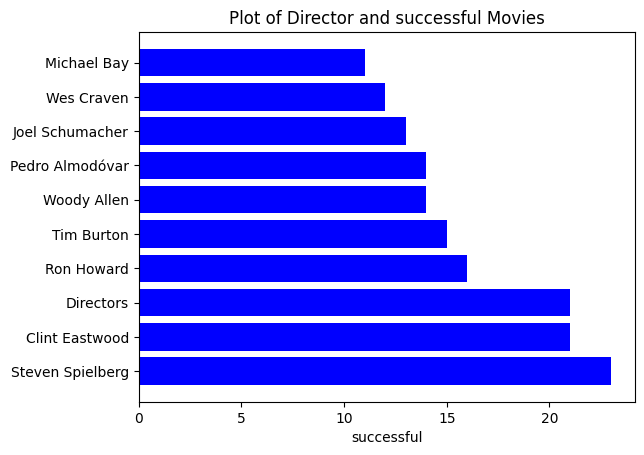

In [19]:
# Group by 'Director' and sum 'Revenue'
grouped_df = movies_metadata_df.groupby('director')['successful'].sum().reset_index()

# Sort the DataFrame by 'Revenue' in descending order for better visualization
grouped_df = grouped_df.sort_values('successful', ascending=False).head(10)

# Create a horizontal bar plot
plt.barh(grouped_df['director'], grouped_df['successful'], color='blue')
plt.xlabel('successful')
plt.title('Plot of Director and successful Movies')
plt.show()

In [20]:
def is_condition_1(row):
    revenue_condition = row['gross'] >= 2 * row['budget']
    return revenue_condition

movies_metadata_df['condition_1'] = movies_metadata_df.apply(is_condition_1, axis=1)

In [21]:
movies_metadata_df['successful'] = movies_metadata_df['successful'].astype(int)

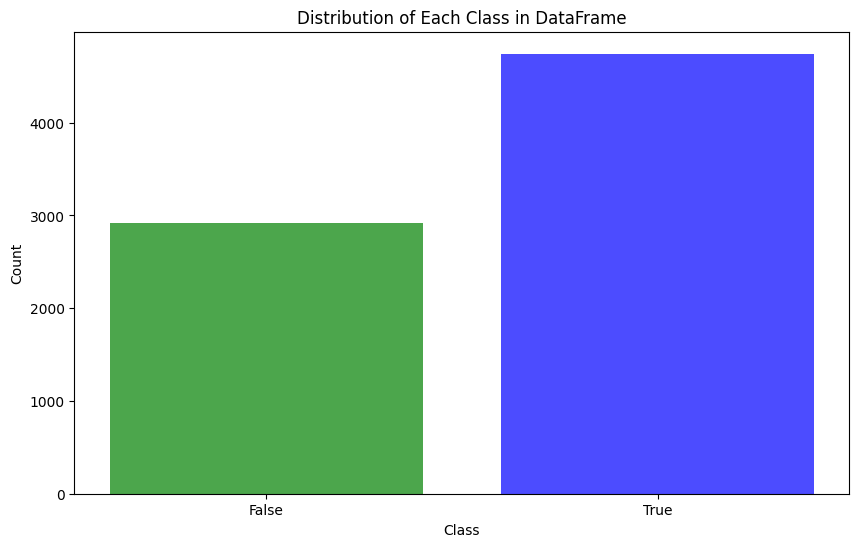

In [22]:
class_counts = movies_metadata_df['successful'].value_counts()

plt.figure(figsize=(10,6))
plt.bar(class_counts.index, class_counts.values, color=['b', 'g'], alpha=0.7)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Distribution of Each Class in DataFrame')
plt.xticks(ticks=[0,1], labels=['False', 'True'])
plt.show()


# 2. EDA (Exploratory Data Analysis)



## 2.1. Distribution of Numerical Features
   - Distribution of `budget`, `revenue`, `runtime`, and `num_production_companies`.

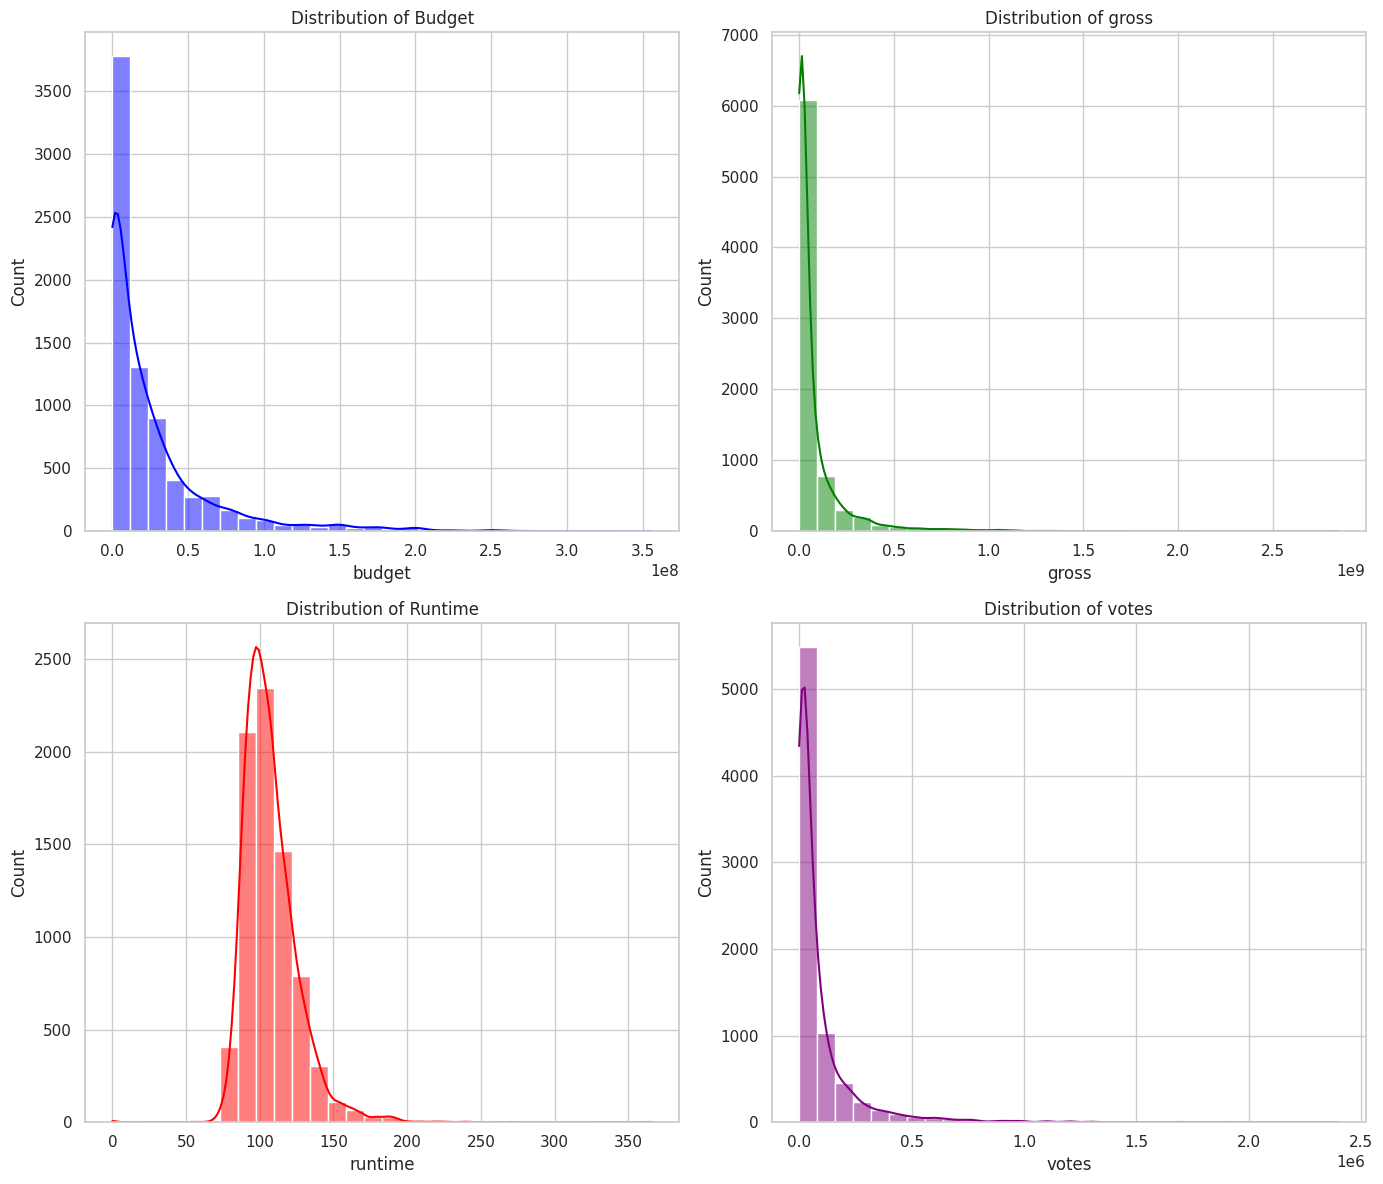

In [23]:
# Setting the style of seaborn
sns.set(style="whitegrid")

# 1. Distribution of Numerical Features
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 12))
sns.histplot(data=movies_metadata_df, x='budget', bins=30, ax=axes[0, 0], kde=True, color='blue')
axes[0, 0].set_title('Distribution of Budget')
sns.histplot(data=movies_metadata_df, x='gross', bins=30, ax=axes[0, 1], kde=True, color='green')
axes[0, 1].set_title('Distribution of gross')
sns.histplot(data=movies_metadata_df, x='runtime', bins=30, ax=axes[1, 0], kde=True, color='red')
axes[1, 0].set_title('Distribution of Runtime')
sns.histplot(data=movies_metadata_df, x='votes', bins=30, ax=axes[1, 1], kde=True, color='purple')
axes[1, 1].set_title('Distribution of votes')
plt.tight_layout()
plt.show()


In [24]:
movies_metadata_df.shape

(7668, 17)

The histograms above provide insights into the distribution of `budget`, `revenue`, `runtime`, and `number of production companies`:

- **Budget**: Most movies have a budget less than 150 million, with a peak at lower budgets.
- **Revenue**: A similar trend is observed in revenue, with most movies earning less than 100 million.
- **Runtime**: The majority of movies have a runtime around 80 to 120 minutes.
- **Number of Production Companies**: Most movies are associated with just one production company, and very few movies have more than 5 production companies involved.

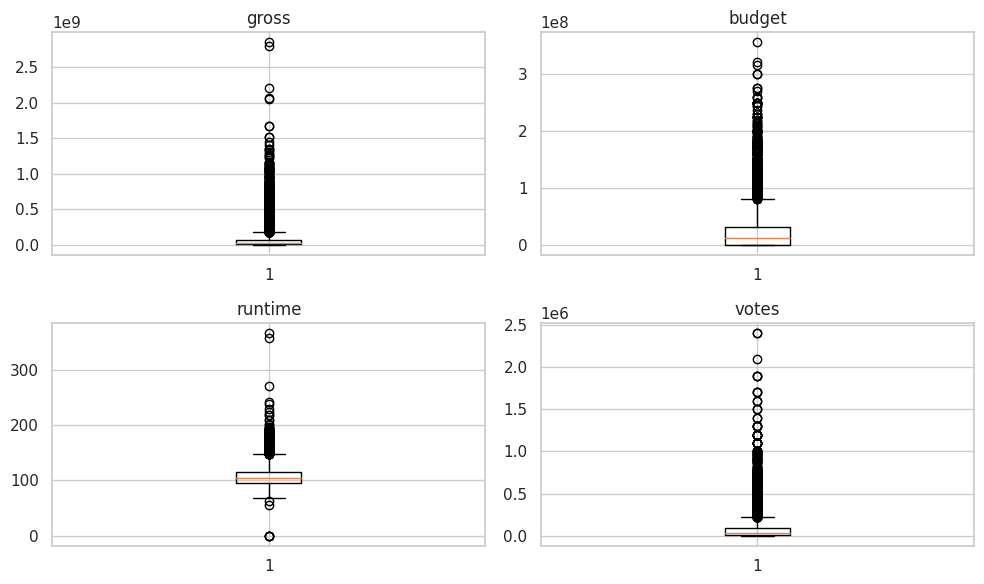

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have your data in a DataFrame named 'movies_metadata_df'
columns_to_plot = ['gross', 'budget', 'runtime', 'votes']

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 6))

# Plot each column in a separate boxplot
for i, col in enumerate(columns_to_plot):
    row = i // 2  # Calculate row index
    col_index = i % 2  # Calculate column index
    axes[row, col_index].boxplot(movies_metadata_df[col])
    axes[row, col_index].set_title(col)

plt.tight_layout()
plt.show()


## 2.2. Categorical Feature Analysis
   - Number of movies per `primary_genre` and `primary_production_country`.

In [26]:
movies_metadata_df.columns

Index(['rating', 'genre', 'year', 'released', 'score', 'votes', 'director',
       'writer', 'star', 'country', 'budget', 'gross', 'company', 'runtime',
       'month', 'successful', 'condition_1'],
      dtype='object')

<ipython-input-27-5b515280032c>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=movies_metadata_df, y='genre', order=movies_metadata_df['genre'].value_counts().index, palette="viridis")


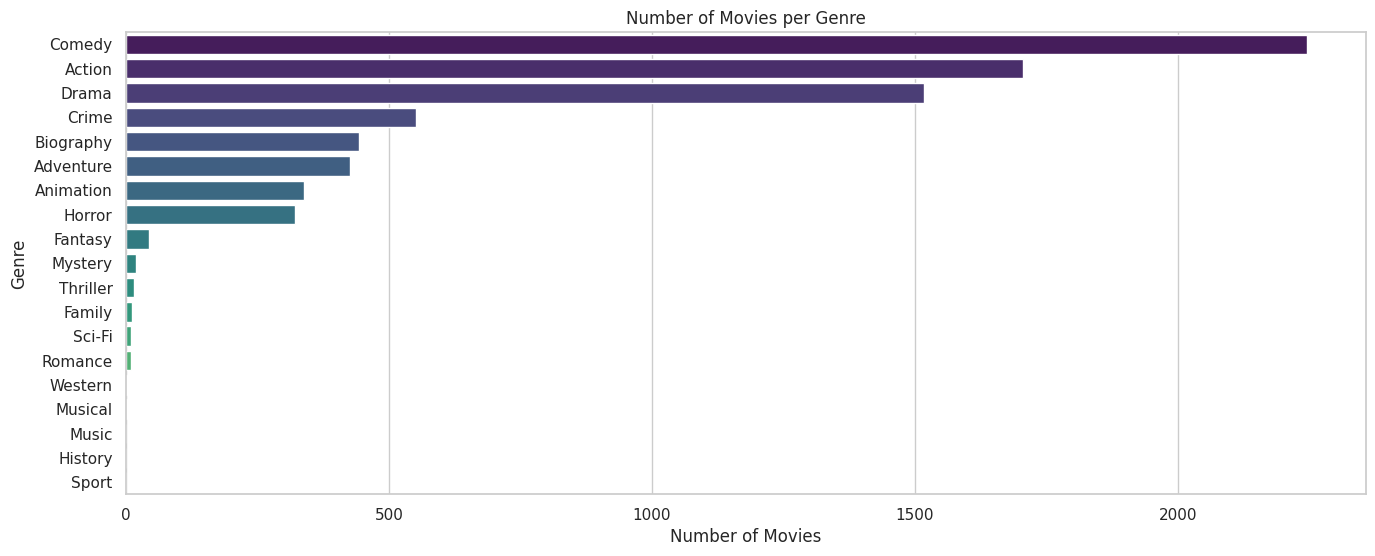

In [27]:
# 2. Categorical Feature Analysis

# Number of Movies per Primary Genre
plt.figure(figsize=(16, 6))
sns.countplot(data=movies_metadata_df, y='genre', order=movies_metadata_df['genre'].value_counts().index, palette="viridis")
plt.title('Number of Movies per Genre')
plt.xlabel('Number of Movies')
plt.ylabel('Genre')
plt.show()

# # Number of Movies per Primary Production Country (Top 20)
# plt.figure(figsize=(16, 6))
# sns.countplot(data=movies_metadata_df, y='primary_production_country', order=movies_metadata_df['primary_production_country'].value_counts().head(20).index, palette="viridis")
# plt.title('Number of Movies per Primary Production Country (Top 20)')
# plt.xlabel('Number of Movies')
# plt.ylabel('Primary Production Country')
# plt.show()


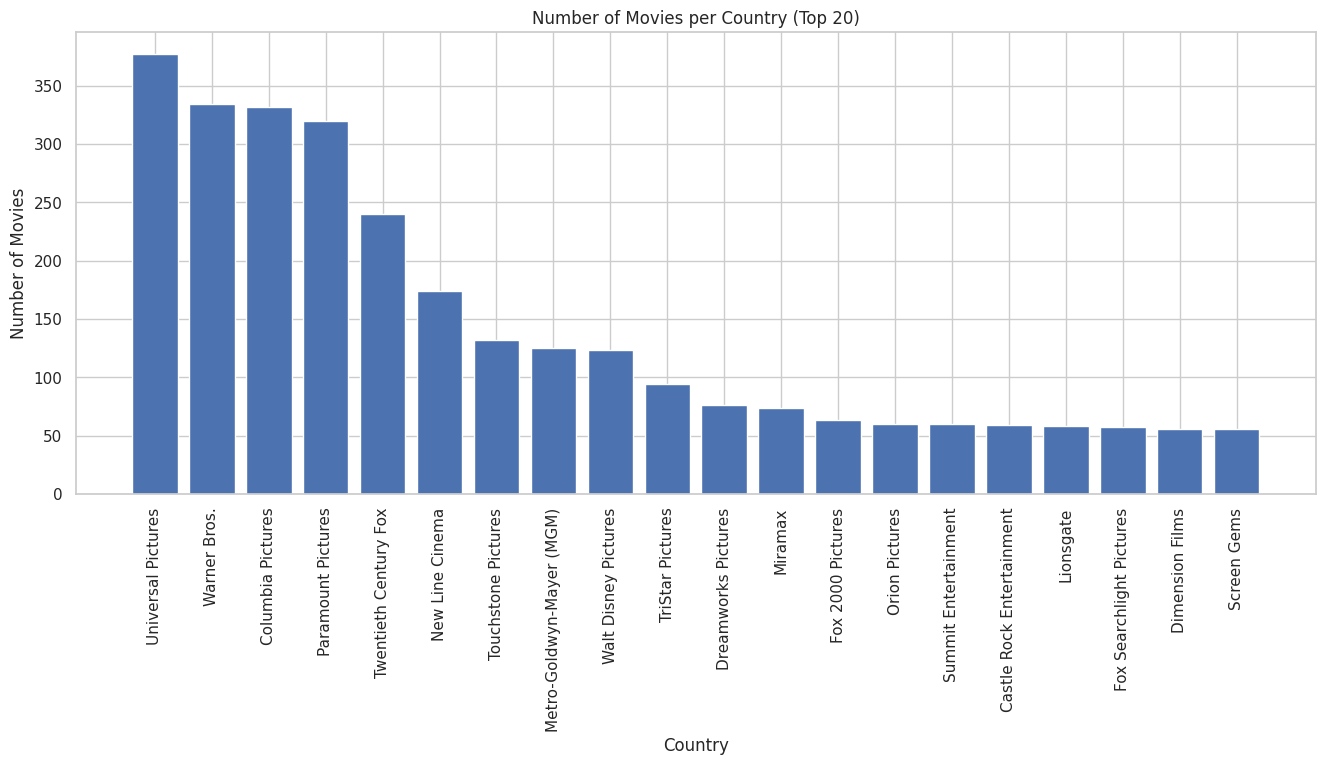

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

top_20_counts = movies_metadata_df['company'].value_counts().head(20)

plt.figure(figsize=(16, 6))
plt.bar(top_20_counts.index, top_20_counts.values)
plt.title('Number of Movies per Country (Top 20)')
plt.xlabel('Country')
plt.ylabel('Number of Movies')
plt.xticks(rotation=90)  # Rotate x-axis labels for readability
plt.show()


## 2.3. Time-based Analysis
   - Number of movies released each year (`release_year`).
   - Monthly distribution of movie releases (`release_month`).
   

<ipython-input-29-c7aacc71e78a>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=movies_metadata_df, x='month', palette="viridis")


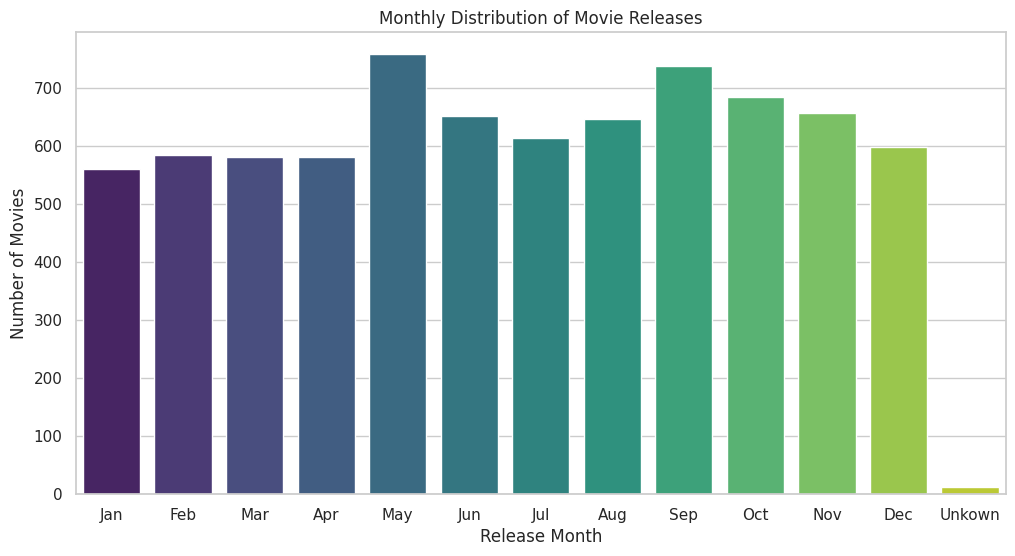

In [29]:
# 3. Time-based Analysis

# # Number of Movies Released Each Year
# plt.figure(figsize=(18, 6))
# sns.countplot(data=movies_metadata_df, x='release_year', palette="viridis")
# plt.title('Number of Movies Released Each Year')
# plt.xlabel('Release Year')
# plt.ylabel('Number of Movies')
# plt.xticks(rotation=90)
# plt.show()

# Monthly Distribution of Movie Releases
plt.figure(figsize=(12, 6))
sns.countplot(data=movies_metadata_df, x='month', palette="viridis")
plt.title('Monthly Distribution of Movie Releases')
plt.xlabel('Release Month')
plt.ylabel('Number of Movies')
plt.xticks(ticks=range(13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec','Unkown'])
plt.show()


## 2.4. Correlation Analysis
   - Correlation between numerical features.

In [30]:
def get_pearson_corr_matrix(df: pd.DataFrame) -> pd.DataFrame:
    ### BEGIN SOLUTION
    correlation_matrix = df.corr(method='pearson')
    return correlation_matrix
    ### END SOLUTION
    pass

In [31]:
movies_metadata_df.columns

Index(['rating', 'genre', 'year', 'released', 'score', 'votes', 'director',
       'writer', 'star', 'country', 'budget', 'gross', 'company', 'runtime',
       'month', 'successful', 'condition_1'],
      dtype='object')

In [32]:
df = movies_metadata_df[['year', 'score', 'votes', 'budget', 'gross', 'runtime']]

In [33]:
# Tạo correlation matrix từ hàm đã viết
corr_matrix = get_pearson_corr_matrix(df)

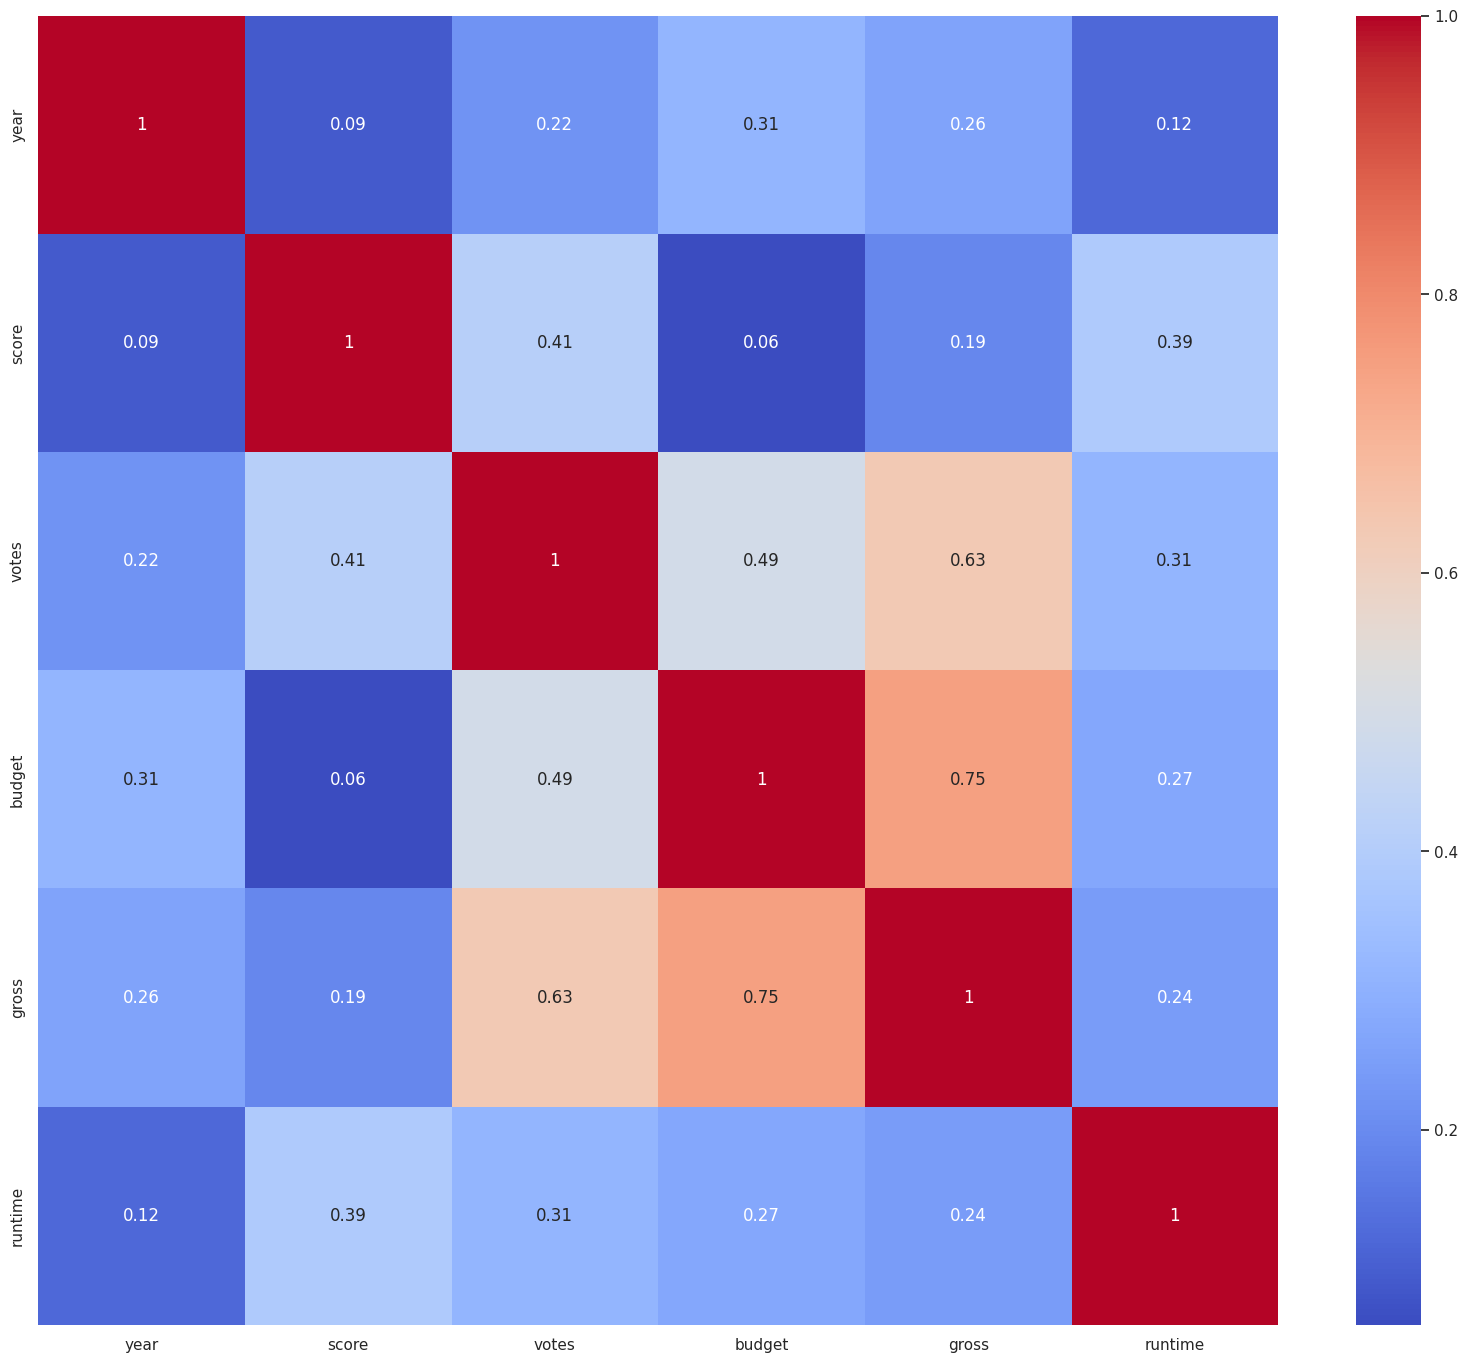

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 17))
sns.heatmap(corr_matrix.round(2), annot=True, cmap='coolwarm')
plt.show()

## 2.5. Analysis the impact of features to successful movie (6 questions)


### 2.5.1 budget and revenue

**Question: Does a higher budget generally lead to higher revenue?**

In [35]:
movies_metadata_df.columns

Index(['rating', 'genre', 'year', 'released', 'score', 'votes', 'director',
       'writer', 'star', 'country', 'budget', 'gross', 'company', 'runtime',
       'month', 'successful', 'condition_1'],
      dtype='object')

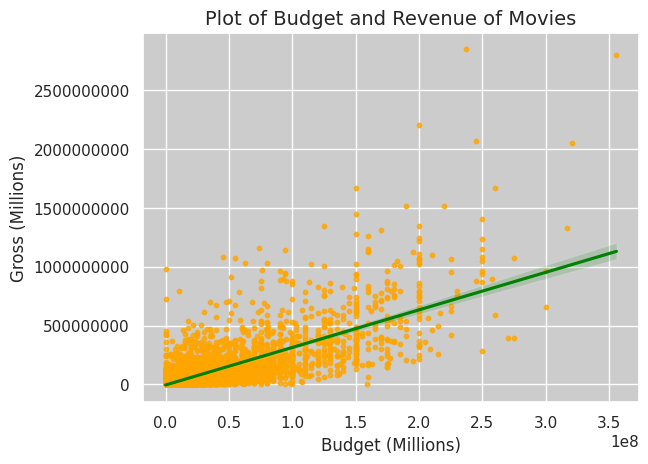

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="darkgrid", rc={"axes.facecolor": ".8"})  # Grey background

# Create scatter plot with regression line
sns.regplot(x='budget', y='gross', data=df,
            scatter_kws={'s': 10, 'color': 'orange'},
            line_kws={'color': 'green'})

# Add labels and title
plt.xlabel('Budget (Millions)', fontsize=12)
plt.ylabel('Gross (Millions)', fontsize=12)
plt.title('Plot of Budget and Revenue of Movies', fontsize=14)

# Format y-axis to display numbers in millions (e.g., 200 million)
# You'll need to modify this based on your data's scale
plt.ticklabel_format(style='plain', axis='y')

# Display the plot
plt.show()


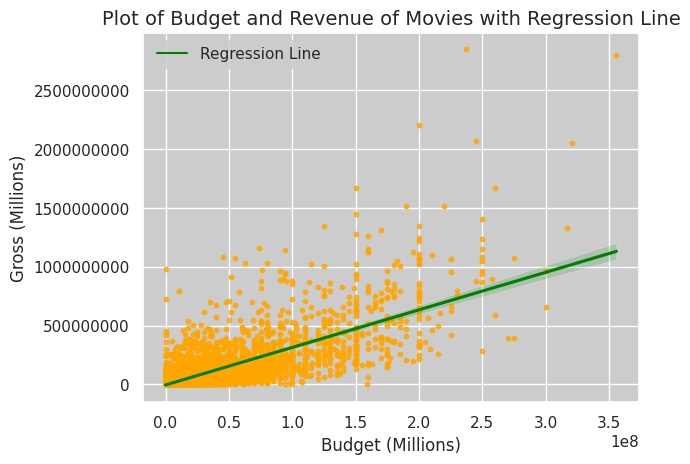

In [37]:
from sklearn.linear_model import LinearRegression

# Create a linear regression model
model = LinearRegression()

# Fit the model to the data
model.fit(movies_metadata_df[['budget']], movies_metadata_df['gross'])

# Get coefficients
m = model.coef_[0]  # Slope (coefficient of budget)
b = model.intercept_  # Y-intercept

# Predict gross revenue based on different budgets
budget_range = range(0, 110, 10)  # Range of budgets to predict for
predicted_gross = [m * budget + b for budget in budget_range]

# Create scatter plot with regression line
sns.set_theme(style="darkgrid", rc={"axes.facecolor": ".8"})  # Grey background

sns.regplot(x='budget', y='gross', data=df,
            scatter_kws={'s': 10, 'color': 'orange'},
            line_kws={'color': 'green'})

# Plot the regression line
plt.plot(budget_range, predicted_gross, color='green', label='Regression Line')

# Add labels and title
plt.xlabel('Budget (Millions)', fontsize=12)
plt.ylabel('Gross (Millions)', fontsize=12)
plt.title('Plot of Budget and Revenue of Movies with Regression Line', fontsize=14)

# Format y-axis to display numbers in millions (e.g., 200 million)
# You'll need to modify this based on your data's scale
plt.ticklabel_format(style='plain', axis='y')

# Add legend
plt.legend()

# Display the plot
plt.show()

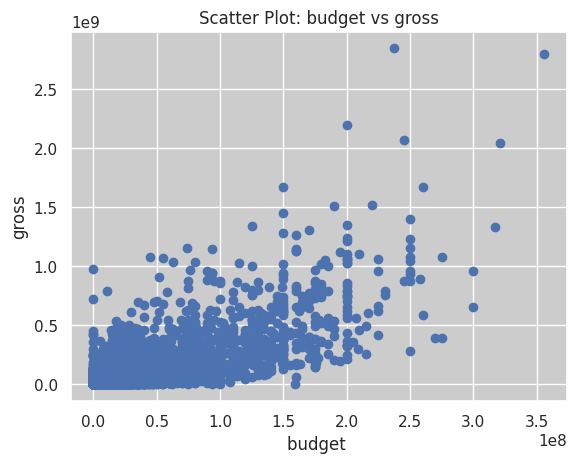

In [38]:
plt.scatter(movies_metadata_df['budget'], movies_metadata_df['gross'])
plt.xlabel('budget ')
plt.ylabel('gross')
plt.title('Scatter Plot: budget vs gross')
plt.show()

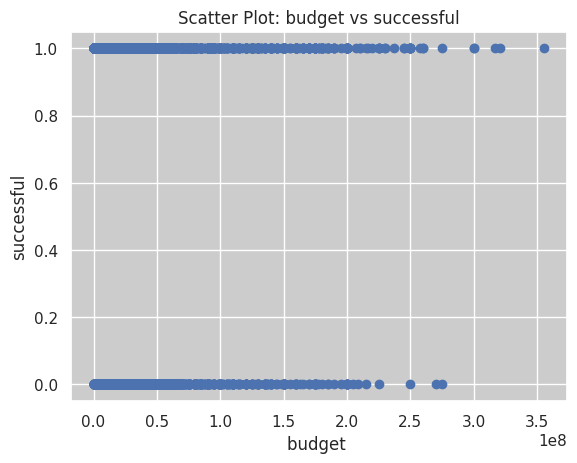

In [39]:
plt.scatter(movies_metadata_df['budget'], movies_metadata_df['successful'])
plt.xlabel('budget ')
plt.ylabel('successful')
plt.title('Scatter Plot: budget vs successful')
plt.show()

=> Number of budget do not affect successful label

**=> Không bàn cãi, budget vs revenue tuyến tính với nhau**

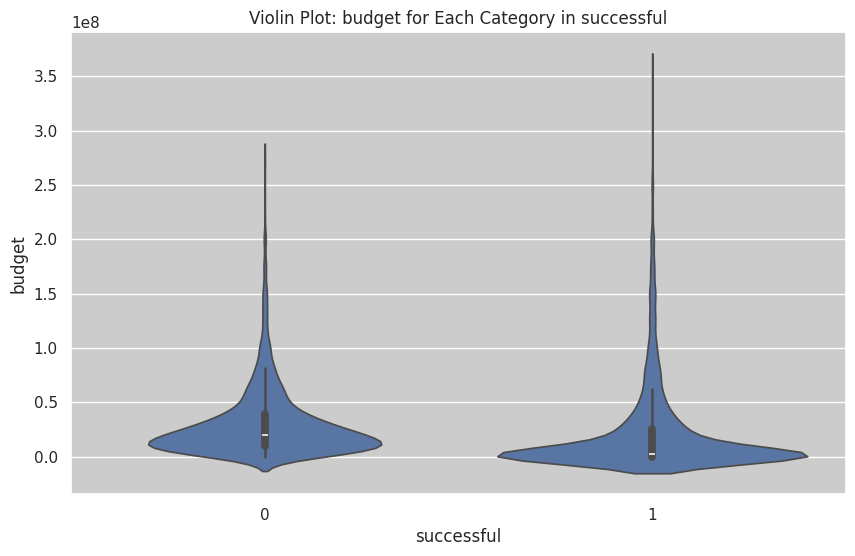

In [40]:
plt.figure(figsize=(10,6))
sns.violinplot(x='successful', y='budget', data=movies_metadata_df)
plt.title('Violin Plot: budget for Each Category in successful')
plt.show()


**=> Get no insight**

### 2.5.5 gross vs director

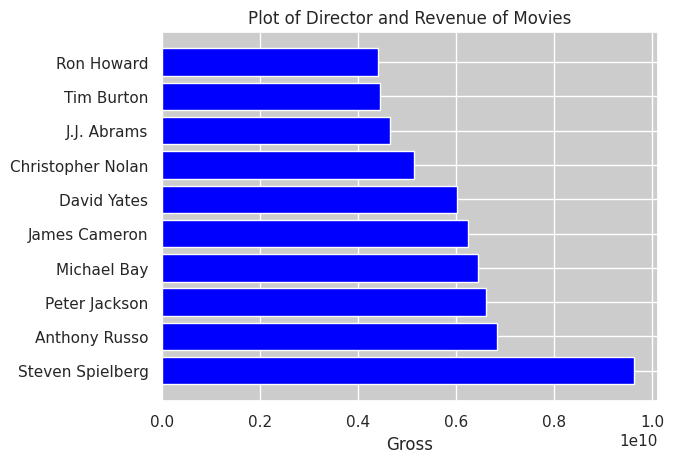

In [41]:
# Group by 'Director' and sum 'Revenue'
grouped_df = movies_metadata_df.groupby('director')['gross'].sum().reset_index()

# Sort the DataFrame by 'Revenue' in descending order for better visualization
grouped_df = grouped_df.sort_values('gross', ascending=False).head(10)

# Create a horizontal bar plot
plt.barh(grouped_df['director'], grouped_df['gross'], color='blue')
plt.xlabel('Gross')
plt.title('Plot of Director and Revenue of Movies')
plt.show()

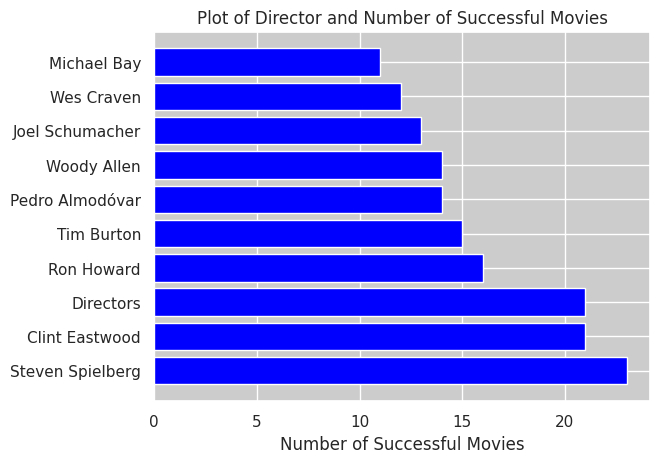

In [42]:
# Group by 'director' and count 'successful' movies
grouped_df = movies_metadata_df[movies_metadata_df['successful'] == 1].groupby('director').size().reset_index(name='count')

# Sort the DataFrame by 'count' in descending order and get the top 15
grouped_df = grouped_df.sort_values('count', ascending=False).head(10)

# Create a horizontal bar plot
plt.barh(grouped_df['director'], grouped_df['count'], color='blue')
plt.xlabel('Number of Successful Movies')
plt.title('Plot of Director and Number of Successful Movies')
plt.show()


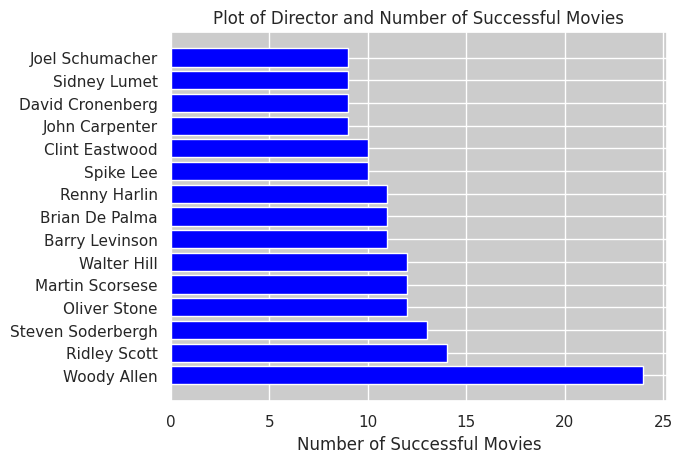

In [43]:
# Group by 'director' and count 'successful' movies
grouped_df = movies_metadata_df[movies_metadata_df['successful'] == 0].groupby('director').size().reset_index(name='count')

# Sort the DataFrame by 'count' in descending order and get the top 15
grouped_df = grouped_df.sort_values('count', ascending=False).head(15)

# Create a horizontal bar plot
plt.barh(grouped_df['director'], grouped_df['count'], color='blue')
plt.xlabel('Number of Successful Movies')
plt.title('Plot of Director and Number of Successful Movies')
plt.show()


###2.5.6 gross vs company

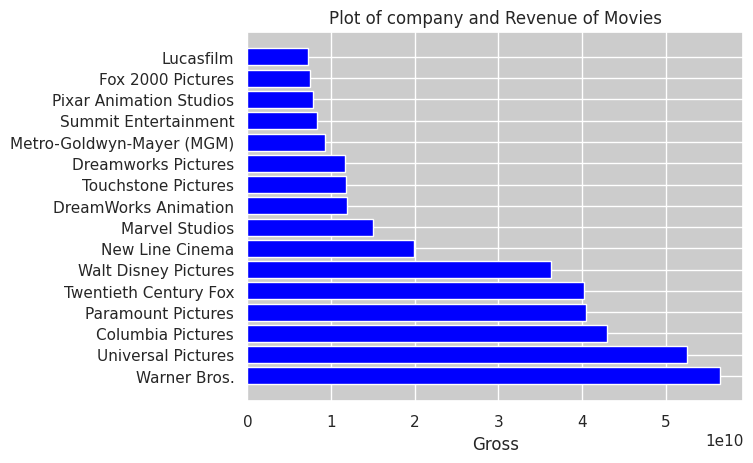

In [44]:
# Group by 'Director' and sum 'Revenue'
grouped_df = movies_metadata_df.groupby('company')['gross'].sum().reset_index()

# Sort the DataFrame by 'Revenue' in descending order for better visualization
grouped_df = grouped_df.sort_values('gross', ascending=False).head(16)

# Create a horizontal bar plot
plt.barh(grouped_df['company'], grouped_df['gross'], color='blue')
plt.xlabel('Gross')
plt.title('Plot of company and Revenue of Movies')
plt.show()

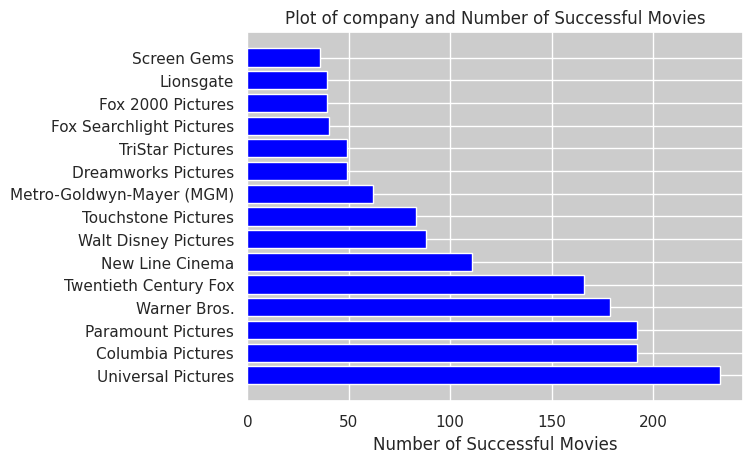

In [45]:
# Group by 'director' and count 'successful' movies
grouped_df = movies_metadata_df[movies_metadata_df['successful'] == 1].groupby('company').size().reset_index(name='count')

# Sort the DataFrame by 'count' in descending order and get the top 15
grouped_df = grouped_df.sort_values('count', ascending=False).head(15)

# Create a horizontal bar plot
plt.barh(grouped_df['company'], grouped_df['count'], color='blue')
plt.xlabel('Number of Successful Movies')
plt.title('Plot of company and Number of Successful Movies')
plt.show()


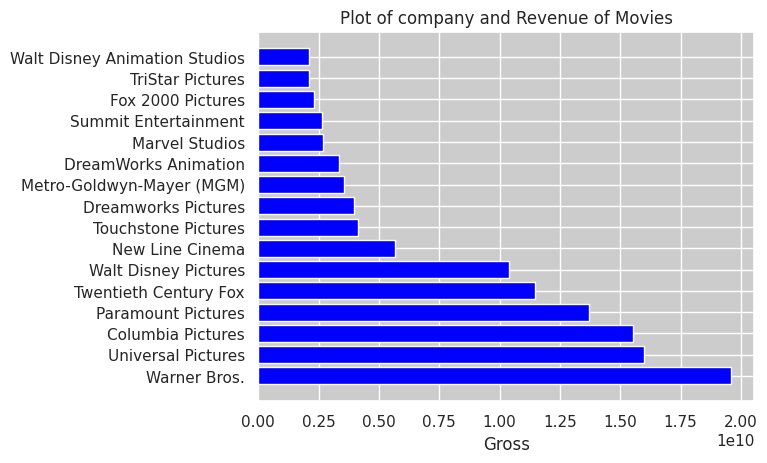

In [46]:
# Group by 'Director' and sum 'Revenue'
grouped_df = movies_metadata_df.groupby('company')['budget'].sum().reset_index()

# Sort the DataFrame by 'Revenue' in descending order for better visualization
grouped_df = grouped_df.sort_values('budget', ascending=False).head(16)

# Create a horizontal bar plot
plt.barh(grouped_df['company'], grouped_df['budget'], color='blue')
plt.xlabel('Gross')
plt.title('Plot of company and Revenue of Movies')
plt.show()

### 2.5.7 Gross vs IMDB Score vs user votes

**Question: How imdb score affect gross?**

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


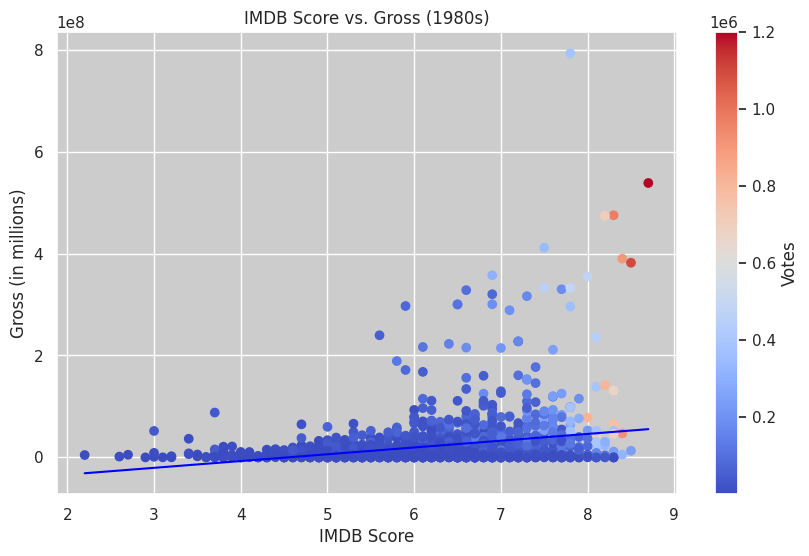

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression


# Filter the DataFrame to only include movies from the 1980s
df = movies_metadata_df[(movies_metadata_df['year'] >= 1980) & (movies_metadata_df['year'] < 1990)]

# Create a scatter plot with a color gradient
plt.figure(figsize=(10, 6))
scatter = plt.scatter(df['score'], df['gross'], c=df['votes'], cmap='coolwarm')
plt.colorbar(scatter, label='Votes')
plt.xlabel('IMDB Score')
plt.ylabel('Gross (in millions)')

# Fit a line of best fit
model = LinearRegression()
model.fit(df[['score']], df['gross'])
x_range = np.linspace(df['score'].min(), df['score'].max(), 100)
plt.plot(x_range, model.predict(x_range.reshape(-1, 1)), color='blue')

plt.title('IMDB Score vs. Gross (1980s)')
plt.show()


**=> Having a good score doesn’t equate to having a high grossing movie. Rather it shows the potential of a movie to reach a high gross.**

**Question: Relationship between IMDB Score and User Vote?**

<ipython-input-48-c4406643b2b2>:7: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=movies_metadata_df, x='score', y='votes' , palette='coolwarm')


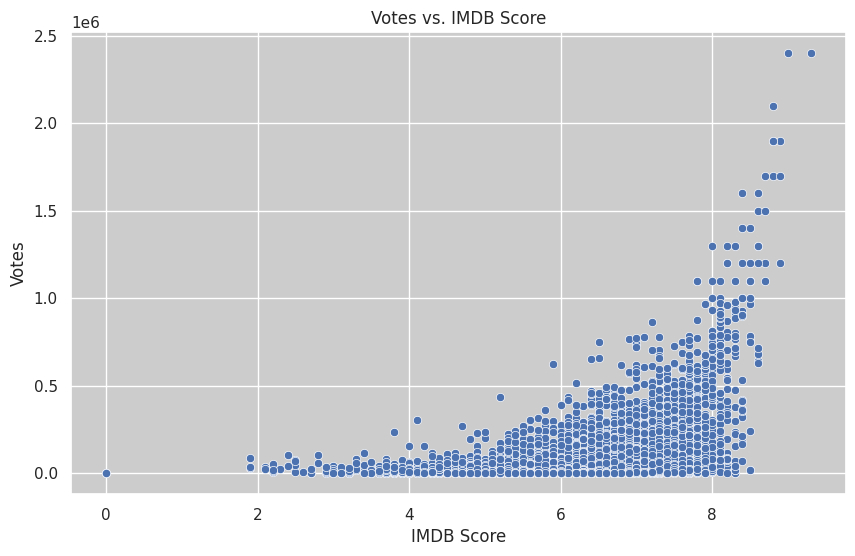

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create a scatter plot with different colors for each content rating
plt.figure(figsize=(10, 6))
sns.scatterplot(data=movies_metadata_df, x='score', y='votes' , palette='coolwarm')
plt.xlabel('IMDB Score')
plt.ylabel('Votes')
plt.title('Votes vs. IMDB Score')
plt.show()


**=> IMDB Score vs User Score is relatively linear**

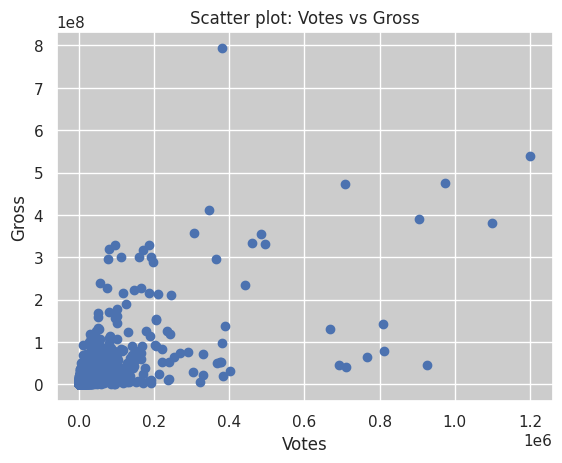

In [49]:
plt.scatter(df['votes'], df['gross'])

plt.title('Scatter plot: Votes vs Gross')
plt.xlabel('Votes')
plt.ylabel('Gross')
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


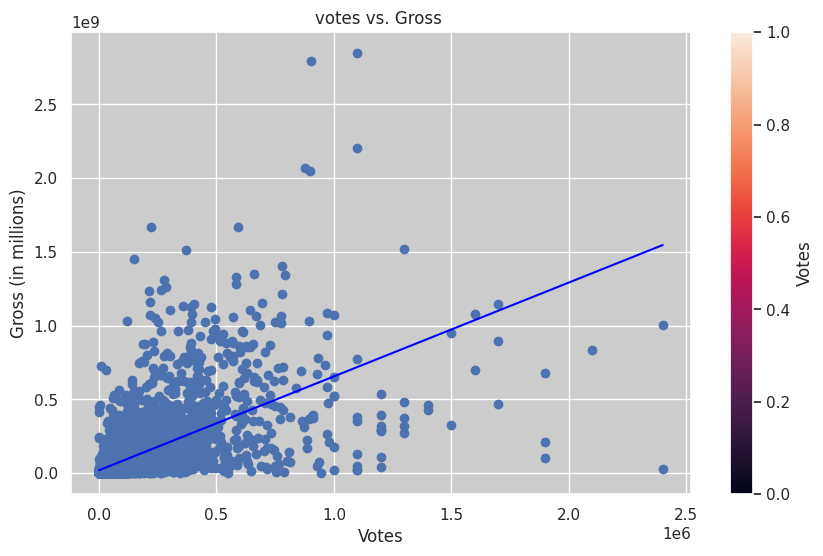

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression


# Filter the DataFrame to only include movies from the 1980s
# df = movies_metadata_df[(movies_metadata_df['year'] >= 1980) & (movies_metadata_df['year'] < 1990)]
df = movies_metadata_df.copy()

# Create a scatter plot with a color gradient
plt.figure(figsize=(10, 6))
scatter = plt.scatter(df['votes'], df['gross'])
plt.colorbar(scatter, label='Votes')
plt.xlabel('Votes')
plt.ylabel('Gross (in millions)')

# Fit a line of best fit
model = LinearRegression()
model.fit(df[['votes']], df['gross'])
x_range = np.linspace(df['votes'].min(), df['votes'].max(), 100)
plt.plot(x_range, model.predict(x_range.reshape(-1, 1)), color='blue')

plt.title('votes vs. Gross ')
plt.show()

**=> Gross vs Votes relatively linear**

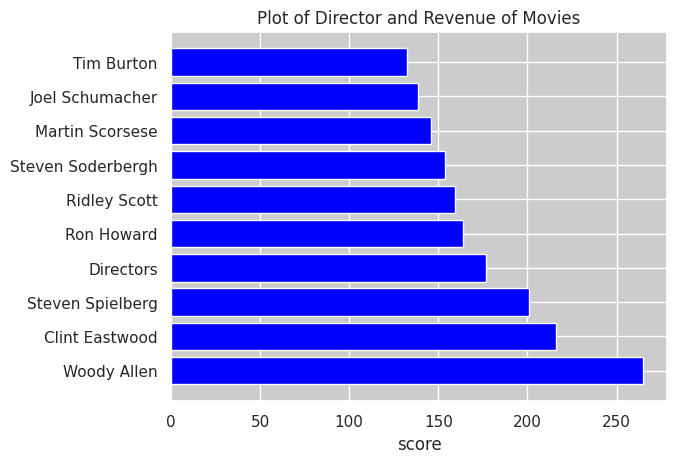

In [51]:
# Group by 'Director' and sum 'Revenue'
grouped_df = movies_metadata_df.groupby('director')['score'].sum().reset_index()

# Sort the DataFrame by 'Revenue' in descending order for better visualization
grouped_df = grouped_df.sort_values('score', ascending=False).head(10)

# Create a horizontal bar plot
plt.barh(grouped_df['director'], grouped_df['score'], color='blue')
plt.xlabel('score')
plt.title('Plot of Director and Revenue of Movies')
plt.show()

### 2.5.8 Gross vs Critics

In [52]:
movies_metadata_df = movies_metadata_df[movies_metadata_df['rating'].str.upper() != 'X']

**Question: How critics affect revenue?**

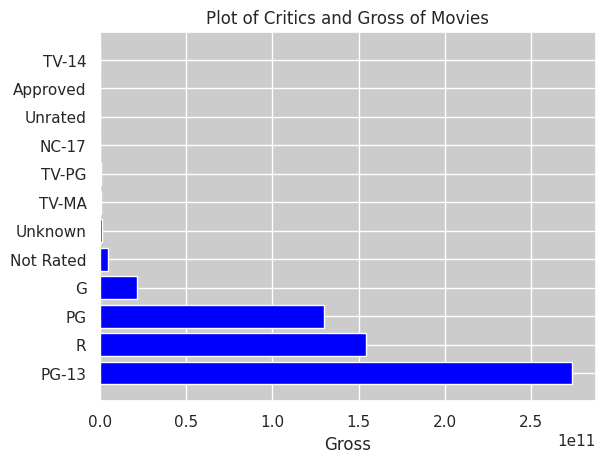

In [53]:
# Group by 'Director' and sum 'Revenue'
grouped_df = movies_metadata_df.groupby('rating')['gross'].sum().reset_index()

# Sort the DataFrame by 'Revenue' in descending order for better visualization
grouped_df = grouped_df.sort_values('gross', ascending=False)

# Create a horizontal bar plot
plt.barh(grouped_df['rating'], grouped_df['gross'], color='blue')
plt.xlabel('Gross')
plt.title('Plot of Critics and Gross of Movies')
plt.show()

**gộp lại thành 4 loại**

=> Những bộ phim giới hạn dưới 13 tuổi có doanh thu cao nhất

=> compare vs revenue >2*budget => prove tuyến tính vs score hoặc vote => successful=> ms gộp vào


In [54]:
movies_metadata_df.columns

Index(['rating', 'genre', 'year', 'released', 'score', 'votes', 'director',
       'writer', 'star', 'country', 'budget', 'gross', 'company', 'runtime',
       'month', 'successful', 'condition_1'],
      dtype='object')

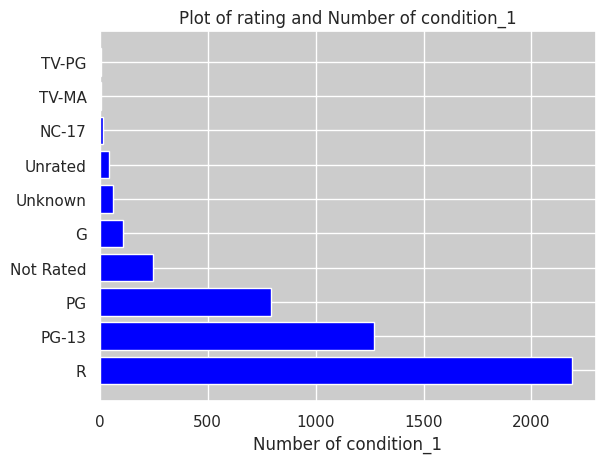

In [55]:
# Group by 'director' and count 'successful' movies
grouped_df = movies_metadata_df[movies_metadata_df['condition_1'] == 1].groupby('rating').size().reset_index(name='count')

# Sort the DataFrame by 'count' in descending order and get the top 15
grouped_df = grouped_df.sort_values('count', ascending=False).head(10)

# Create a horizontal bar plot
plt.barh(grouped_df['rating'], grouped_df['count'], color='blue')
plt.xlabel('Number of condition_1')
plt.title('Plot of rating and Number of condition_1')
plt.show()


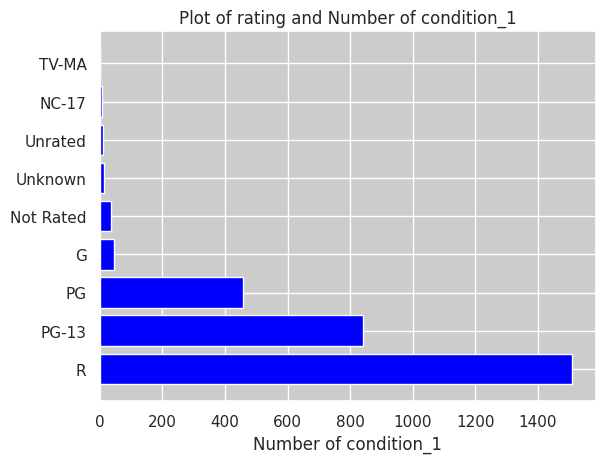

In [56]:
# Group by 'director' and count 'successful' movies
grouped_df = movies_metadata_df[movies_metadata_df['condition_1'] == 0].groupby('rating').size().reset_index(name='count')

# Sort the DataFrame by 'count' in descending order and get the top 15
grouped_df = grouped_df.sort_values('count', ascending=False).head(10)

# Create a horizontal bar plot
plt.barh(grouped_df['rating'], grouped_df['count'], color='blue')
plt.xlabel('Number of condition_1')
plt.title('Plot of rating and Number of condition_1')
plt.show()


=> plot chứng minh revenue > 2*budget và vote và score

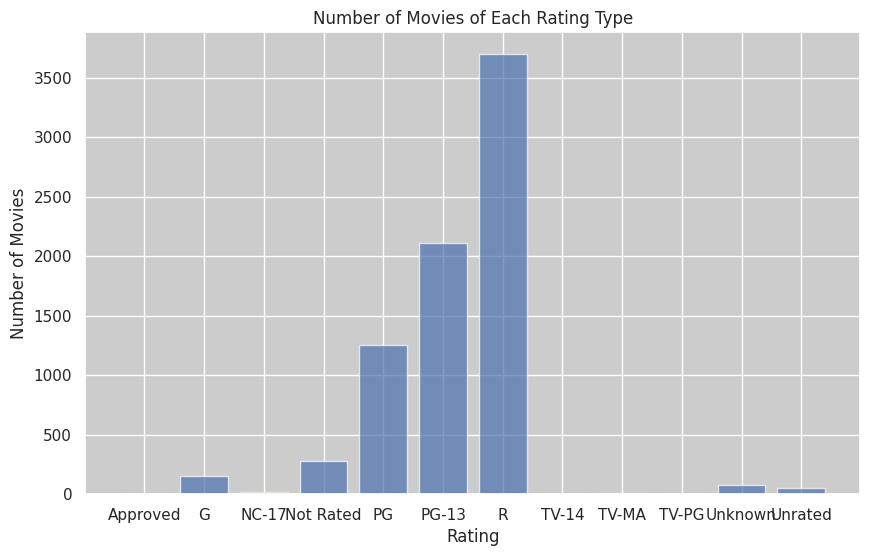

In [57]:
# Count the number of movies for each rating
rating_counts = movies_metadata_df.groupby('rating')['successful'].count()

# Create the bar plot
plt.figure(figsize=(10,6))
plt.bar(rating_counts.index, rating_counts.values, color='b', alpha=0.7)
plt.xlabel('Rating')
plt.ylabel('Number of Movies')
plt.title('Number of Movies of Each Rating Type')
plt.show()

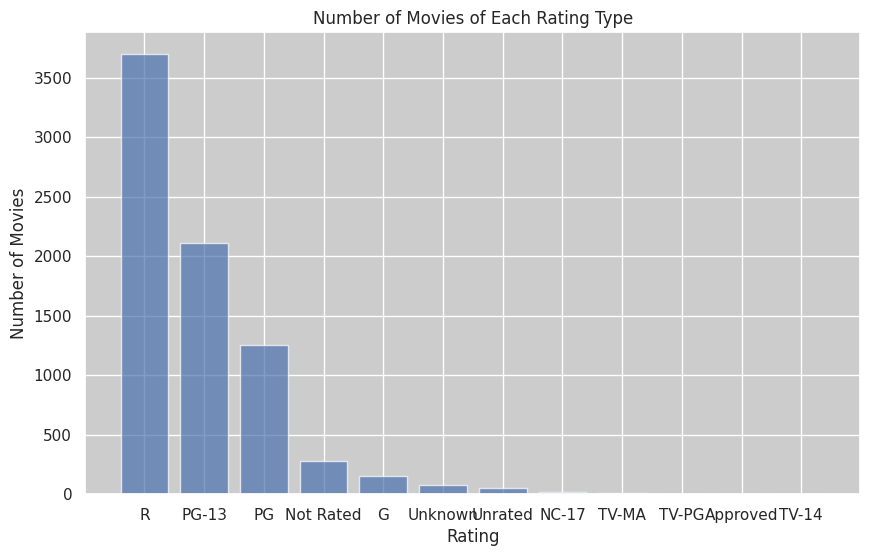

In [58]:
# Count the number of movies for each rating
rating_counts = movies_metadata_df['rating'].value_counts()

# Create the bar plot
plt.figure(figsize=(10,6))
plt.bar(rating_counts.index, rating_counts.values, color='b', alpha=0.7)
plt.xlabel('Rating')
plt.ylabel('Number of Movies')
plt.title('Number of Movies of Each Rating Type')
plt.show()

Nhận thấy, PG-13 có doanh thu cao nhất dù số lượng phim đứng sau R.
Tương tự Not Rated có số lượng phim nhiều hơn nhưng doanh thu thấp hơn.

**=> Như vậy, những critics rating nhất định sẽ có ảnh hưởng tới gross của bộ phim**

### 2.5.9 Genre vs Gross

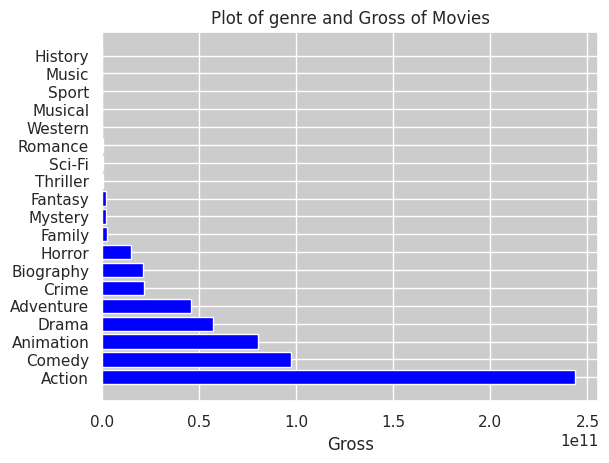

In [59]:
# Group by 'Director' and sum 'Revenue'
grouped_df = movies_metadata_df.groupby('genre')['gross'].sum().reset_index()

# Sort the DataFrame by 'Revenue' in descending order for better visualization
grouped_df = grouped_df.sort_values('gross', ascending=False)

# Create a horizontal bar plot
plt.barh(grouped_df['genre'], grouped_df['gross'], color='blue')
plt.xlabel('Gross')
plt.title('Plot of genre and Gross of Movies')
plt.show()

In [60]:
movies_metadata_df.columns

Index(['rating', 'genre', 'year', 'released', 'score', 'votes', 'director',
       'writer', 'star', 'country', 'budget', 'gross', 'company', 'runtime',
       'month', 'successful', 'condition_1'],
      dtype='object')

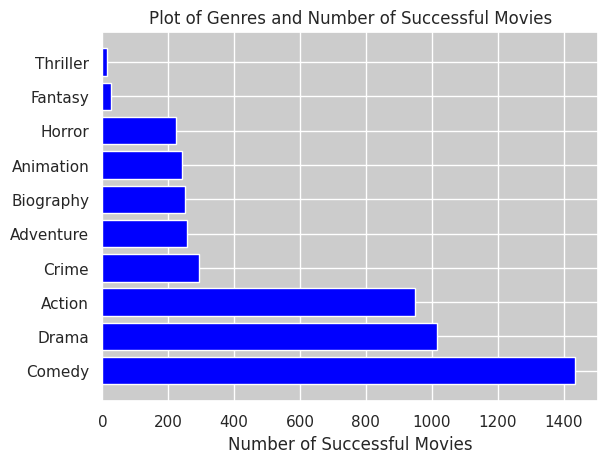

In [61]:
# Group by 'director' and count 'successful' movies
grouped_df = movies_metadata_df[movies_metadata_df['successful'] == 1].groupby('genre').size().reset_index(name='count')

# Sort the DataFrame by 'count' in descending order and get the top 15
grouped_df = grouped_df.sort_values('count', ascending=False).head(10)

# Create a horizontal bar plot
plt.barh(grouped_df['genre'], grouped_df['count'], color='blue')
plt.xlabel('Number of Successful Movies')
plt.title('Plot of Genres and Number of Successful Movies')
plt.show()


rating vs season vs successful

genre vs season vs successful

genre vs director / star

### 2.5.10 Genre vs year

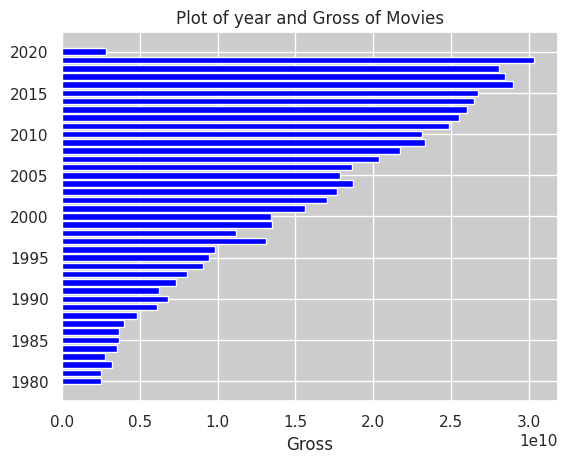

In [62]:
# Group by 'Director' and sum 'Revenue'
grouped_df = movies_metadata_df.groupby('year')['gross'].sum().reset_index()

# Sort the DataFrame by 'Revenue' in descending order for better visualization
grouped_df = grouped_df.sort_values('gross', ascending=False)

# Create a horizontal bar plot
plt.barh(grouped_df['year'], grouped_df['gross'], color='blue')
plt.xlabel('Gross')
plt.title('Plot of year and Gross of Movies')
plt.show()

### 2.5.11 Month vs Gross

In [63]:
movies_metadata_df['month'].unique()

array(['June', 'July', 'May', 'December', 'October', 'September',
       'February', 'April', 'August', 'March', 'November', 'January',
       'Unknown'], dtype=object)

In [64]:
movies_metadata_df

rating      genre  year  \
name                                                                       
The Shining                                           R      Drama  1980   
The Blue Lagoon                                       R  Adventure  1980   
Star Wars: Episode V - The Empire Strikes Back       PG     Action  1980   
Airplane!                                            PG     Comedy  1980   
Caddyshack                                            R     Comedy  1980   
...                                                 ...        ...   ...   
More to Life                                    Unknown      Drama  2020   
Dream Round                                     Unknown     Comedy  2020   
Saving Mbango                                   Unknown      Drama  2020   
It's Just Us                                    Unknown      Drama  2020   
Tee em el                                       Unknown     Horror  2020   

                                                                        released  \
name                                                                               
The Shining                                        June 13, 1980 (United States)   
The Blue Lagoon                                     July 2, 1980 (United States)   
Star Wars: Episode V - The Empire Strikes Back     June 20, 1980 (United States)   
Airplane!                                           July 2, 1980 (United States)   
Caddyshack                                         July 25, 1980 (United States)   
...                                                                          ...   
More to Life                                    October 23, 2020 (United States)   
Dream Round                                     February 7, 2020 (United States)   
Saving Mbango                                          April 27, 2020 (Cameroon)   
It's Just Us                                     October 1, 2020 (United States)   
Tee em el                                        August 19, 2020 (United States)   

                                                score      votes  \
name                                                               
The Shining                                       8.4   927000.0   
The Blue Lagoon                                   5.8    65000.0   
Star Wars: Episode V - The Empire Strikes Back    8.7  1200000.0   
Airplane!                                         7.7   221000.0   
Caddyshack                                        7.3   108000.0   
...                                               ...        ...   
More to Life                                      3.1       18.0   
Dream Round                                       4.7       36.0   
Saving Mbango                                     5.7       29.0   
It's Just Us                                      0.0        0.0   
Tee em el                                         5.7        7.0   

                                                       director  \
name                                                              
The Shining                                     Stanley Kubrick   
The Blue Lagoon                                  Randal Kleiser   
Star Wars: Episode V - The Empire Strikes Back   Irvin Kershner   
Airplane!                                          Jim Abrahams   
Caddyshack                                         Harold Ramis   
...                                                         ...   
More to Life                                      Joseph Ebanks   
Dream Round                                        Dusty Dukatz   
Saving Mbango                                      Nkanya Nkwai   
It's Just Us                                      James Randall   
Tee em el                                          Pereko Mosia   

                                                                 writer  \
name                                                                      
The Shining                                                S

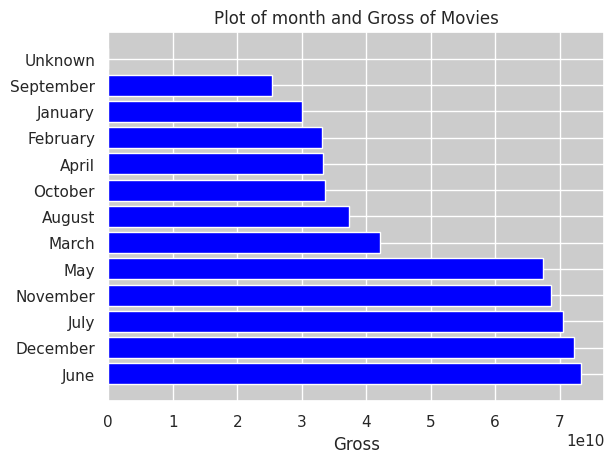

In [65]:
# Group by 'Director' and sum 'Revenue'
grouped_df = movies_metadata_df.groupby('month')['gross'].sum().reset_index()

# Sort the DataFrame by 'Revenue' in descending order for better visualization
grouped_df = grouped_df.sort_values('gross', ascending=False).head(20)

# Create a horizontal bar plot
plt.barh(grouped_df['month'], grouped_df['gross'], color='blue')
plt.xlabel('Gross')
plt.title('Plot of month and Gross of Movies')
plt.show()

**Whether month release affect successful label?**

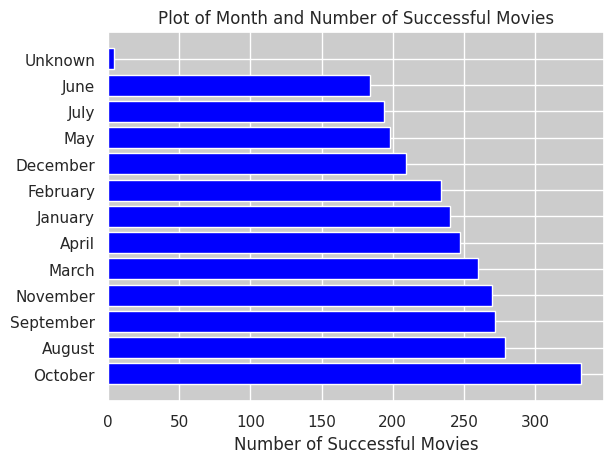

In [66]:
# Group by 'month' and count 'successful' movies
grouped_df = movies_metadata_df[movies_metadata_df['successful'] == 0].groupby('month').size().reset_index(name='count')

# Sort the DataFrame by 'count' in descending order for better visualization
grouped_df = grouped_df.sort_values('count', ascending=False)

# Create a horizontal bar plot
plt.barh(grouped_df['month'], grouped_df['count'], color='blue')
plt.xlabel('Number of Successful Movies')
plt.title('Plot of Month and Number of Successful Movies')
plt.show()

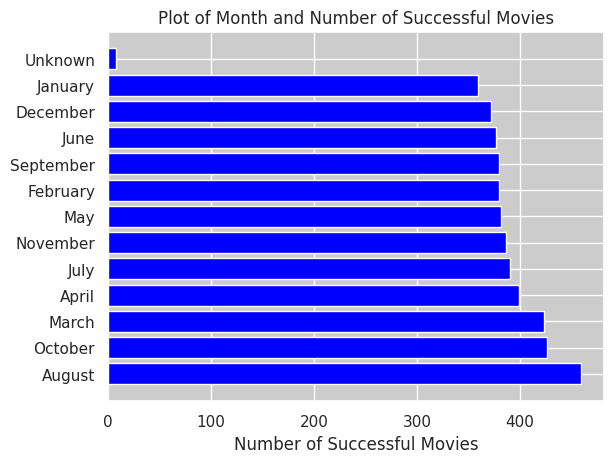

In [67]:
# Group by 'month' and count 'successful' movies
grouped_df = movies_metadata_df[movies_metadata_df['successful'] == 1].groupby('month').size().reset_index(name='count')

# Sort the DataFrame by 'count' in descending order for better visualization
grouped_df = grouped_df.sort_values('count', ascending=False)

# Create a horizontal bar plot
plt.barh(grouped_df['month'], grouped_df['count'], color='blue')
plt.xlabel('Number of Successful Movies')
plt.title('Plot of Month and Number of Successful Movies')
plt.show()

### 2.5.12 writer vs gross

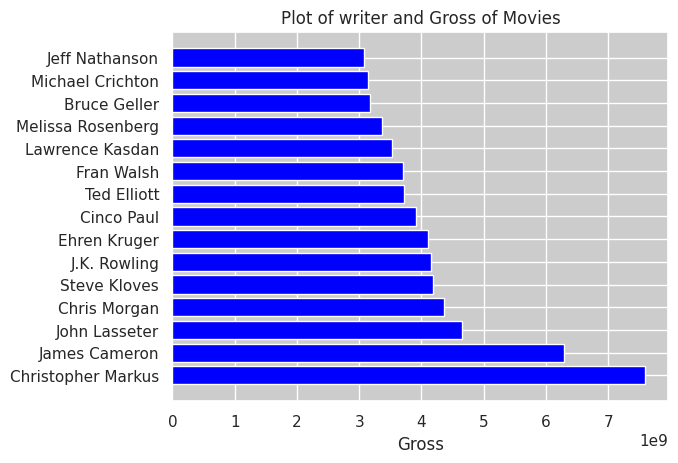

In [68]:
# Group by 'Director' and sum 'Revenue'
grouped_df = movies_metadata_df.groupby('writer')['gross'].sum().reset_index()

# Sort the DataFrame by 'Revenue' in descending order for better visualization
grouped_df = grouped_df.sort_values('gross', ascending=False).head(15)

# Create a horizontal bar plot
plt.barh(grouped_df['writer'], grouped_df['gross'], color='blue')
plt.xlabel('Gross')
plt.title('Plot of writer and Gross of Movies')
plt.show()

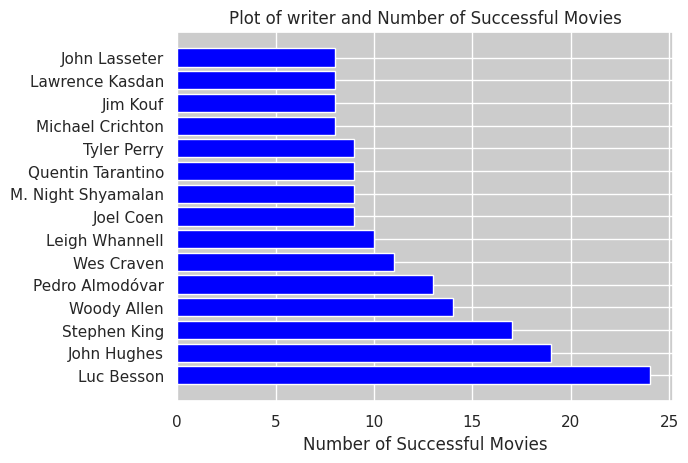

In [69]:
# Group by 'director' and count 'successful' movies
grouped_df = movies_metadata_df[movies_metadata_df['successful'] == 1].groupby('writer').size().reset_index(name='count')

# Sort the DataFrame by 'count' in descending order and get the top 15
grouped_df = grouped_df.sort_values('count', ascending=False).head(15)

# Create a horizontal bar plot
plt.barh(grouped_df['writer'], grouped_df['count'], color='blue')
plt.xlabel('Number of Successful Movies')
plt.title('Plot of writer and Number of Successful Movies')
plt.show()


### 2.5.13 main actor/actress vs gross

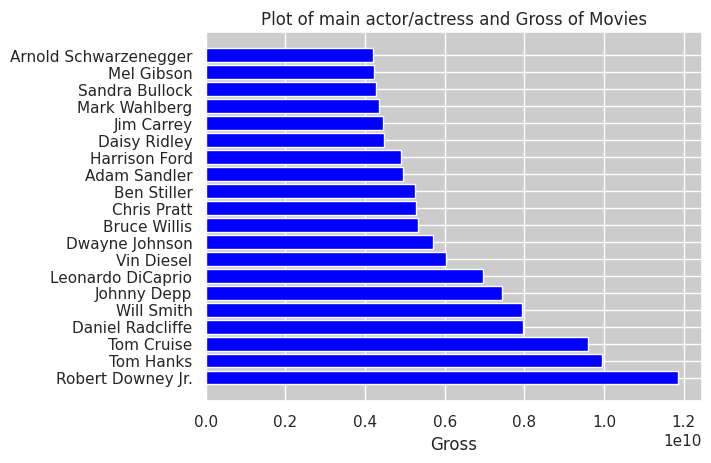

In [70]:
# Group by 'Director' and sum 'Revenue'
grouped_df = movies_metadata_df.groupby('star')['gross'].sum().reset_index()

# Sort the DataFrame by 'Revenue' in descending order for better visualization
grouped_df = grouped_df.sort_values('gross', ascending=False).head(20)

# Create a horizontal bar plot
plt.barh(grouped_df['star'], grouped_df['gross'], color='blue')
plt.xlabel('Gross')
plt.title('Plot of main actor/actress and Gross of Movies')
plt.show()

In [71]:
movies_metadata_df.columns

Index(['rating', 'genre', 'year', 'released', 'score', 'votes', 'director',
       'writer', 'star', 'country', 'budget', 'gross', 'company', 'runtime',
       'month', 'successful', 'condition_1'],
      dtype='object')

### 2.5.14 country vs gross

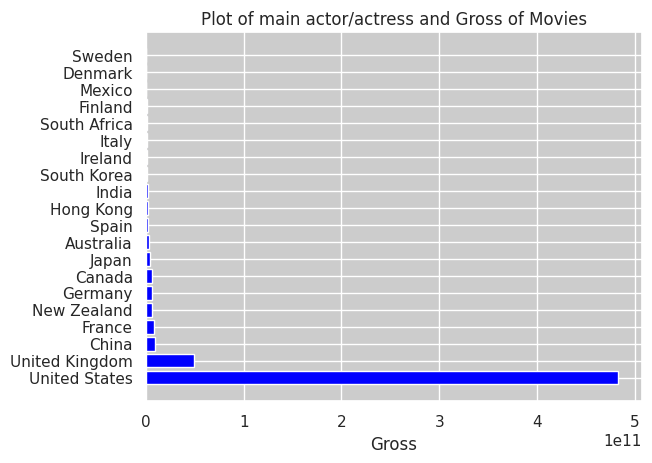

In [72]:
# Group by 'Director' and sum 'Revenue'
grouped_df = movies_metadata_df.groupby('country')['gross'].sum().reset_index()

# Sort the DataFrame by 'Revenue' in descending order for better visualization
grouped_df = grouped_df.sort_values('gross', ascending=False).head(20)

# Create a horizontal bar plot
plt.barh(grouped_df['country'], grouped_df['gross'], color='blue')
plt.xlabel('Gross')
plt.title('Plot of main actor/actress and Gross of Movies')
plt.show()

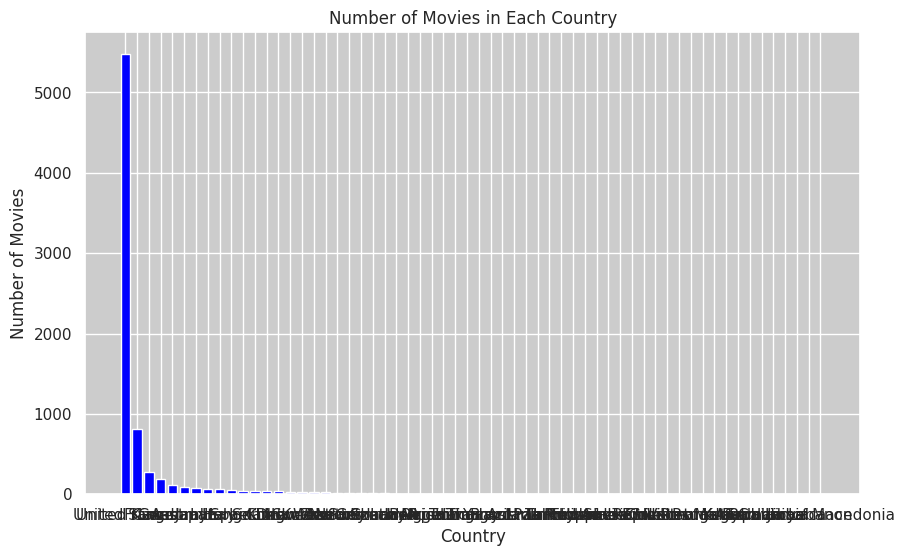

In [73]:
import pandas as pd
import matplotlib.pyplot as plt


# Count the number of movies in each country
country_counts = movies_metadata_df['country'].value_counts()

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(country_counts.index, country_counts.values, color='blue')
plt.xlabel('Country')
plt.ylabel('Number of Movies')
plt.title('Number of Movies in Each Country')
plt.show()


In [74]:
# movies_metadata_df.query('num_production_companies == 20')

The scatter plots above display the relationship between revenue and other features:

- **Revenue vs. Budget**:
  - There is a clear trend indicating that movies with higher budgets generally tend to generate higher revenues.
  - There are also instances of movies with low budgets generating high revenues, indicating the presence of some successful low-budget movies.

- **Revenue vs. Runtime**:
  - There is no distinct trend observed between revenue and runtime.

### 2.5.15 Runtime vs Gross

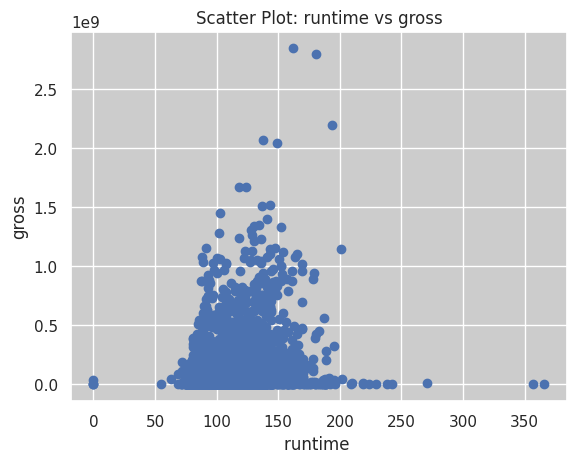

In [75]:
plt.scatter(movies_metadata_df['runtime'], movies_metadata_df['gross'])
plt.xlabel('runtime ')
plt.ylabel('gross')
plt.title('Scatter Plot: runtime vs gross')
plt.show()

In [76]:
movies_metadata_df.columns

Index(['rating', 'genre', 'year', 'released', 'score', 'votes', 'director',
       'writer', 'star', 'country', 'budget', 'gross', 'company', 'runtime',
       'month', 'successful', 'condition_1'],
      dtype='object')

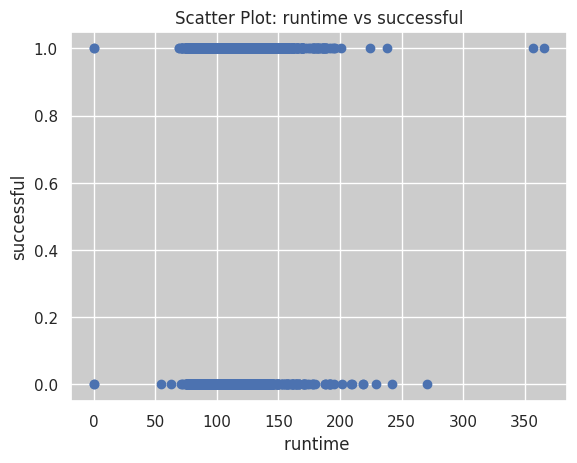

In [77]:
plt.scatter(movies_metadata_df['runtime'], movies_metadata_df['successful'])
plt.xlabel('runtime ')
plt.ylabel('successful')
plt.title('Scatter Plot: runtime vs successful')
plt.show()

=> compare nó với revenue > 2*budget

### 2.5.16 Gross vs Successful

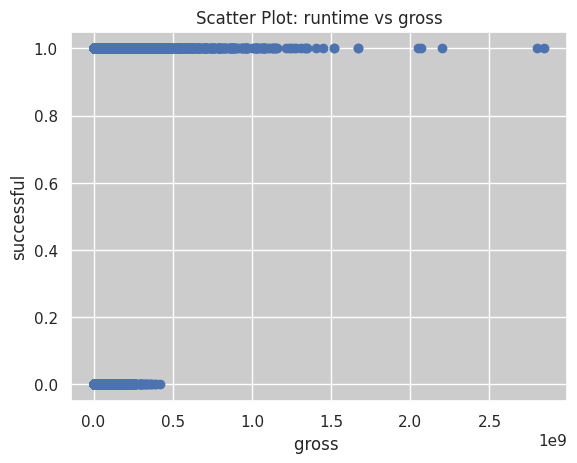

In [78]:
plt.scatter(movies_metadata_df['gross'], movies_metadata_df['successful'])
plt.xlabel('gross ')
plt.ylabel('successful')
plt.title('Scatter Plot: runtime vs gross')
plt.show()

In [79]:
movies_metadata_df.columns

Index(['rating', 'genre', 'year', 'released', 'score', 'votes', 'director',
       'writer', 'star', 'country', 'budget', 'gross', 'company', 'runtime',
       'month', 'successful', 'condition_1'],
      dtype='object')

In [80]:
from sklearn.preprocessing import LabelEncoder

# Assuming you have a DataFrame 'data'
categorical_features = ['genre','company', 'director', 'writer', 'star', 'country']

# Encode categorical features
encoder = LabelEncoder()
for feature in categorical_features:
  movies_metadata_df[f'{feature}_encoded'] = encoder.fit_transform(movies_metadata_df[feature])

In [81]:
month_map = {'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6, 'July': 7,'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12}

# Replace month names with corresponding numbers
movies_metadata_df['month_converted'] = movies_metadata_df['month'].replace(month_map)

In [82]:
movies_metadata_df = movies_metadata_df[movies_metadata_df['month'] != 'Unknown']

In [83]:
movies_metadata_df['month_converted']

name
The Shining                                        6
The Blue Lagoon                                    7
Star Wars: Episode V - The Empire Strikes Back     6
Airplane!                                          7
Caddyshack                                         7
                                                  ..
More to Life                                      10
Dream Round                                        2
Saving Mbango                                      4
It's Just Us                                      10
Tee em el                                          8
Name: month_converted, Length: 7653, dtype: object

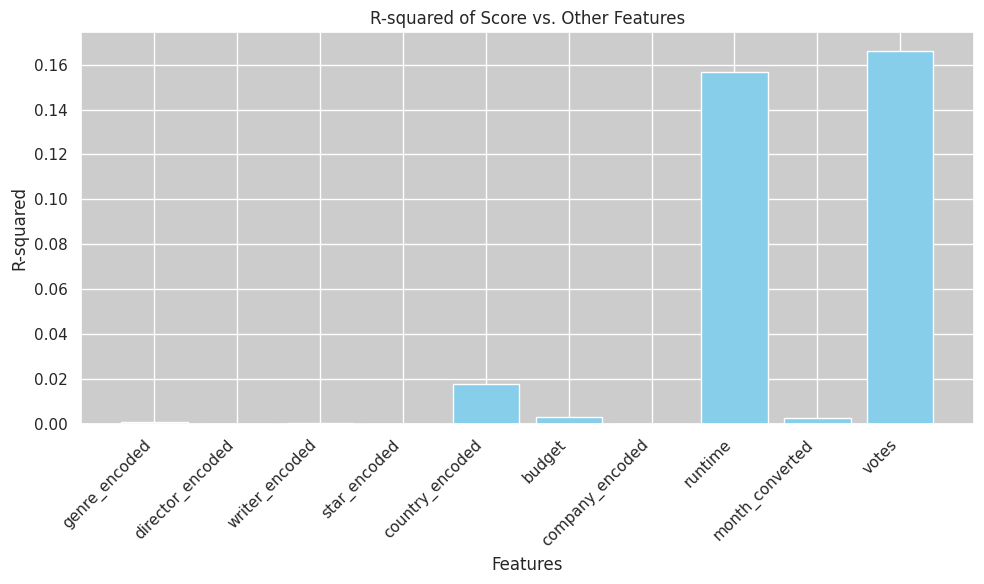

In [84]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt


# Select score as the independent variable
X = movies_metadata_df[['score']]

# List of features to analyze (replace with your actual features)
features = ['genre_encoded', 'director_encoded',
       'writer_encoded', 'star_encoded', 'country_encoded', 'budget', 'company_encoded', 'runtime',
       'month_converted', 'votes']  # Include 'gross' for comparison

# Create an empty list to store R-squared values
r_squared_values = []

# Loop through features
for feature in features:
  y = movies_metadata_df[feature]  # Assign each feature as the dependent variable

  # Rest of the code for model creation, fitting, R-squared calculation
  model = LinearRegression()
  model.fit(X, y)
  predicted_y = model.predict(X)
  r_squared = r2_score(y, predicted_y)
  r_squared_values.append(r_squared)  # Store R-squared for each feature

# Bar chart creation
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.bar(features, r_squared_values, color='skyblue')
plt.xlabel("Features")
plt.ylabel("R-squared")
plt.title("R-squared of Score vs. Other Features")
plt.xticks(rotation=45, ha='right')  # Rotate feature names for readability
plt.tight_layout()
plt.show()


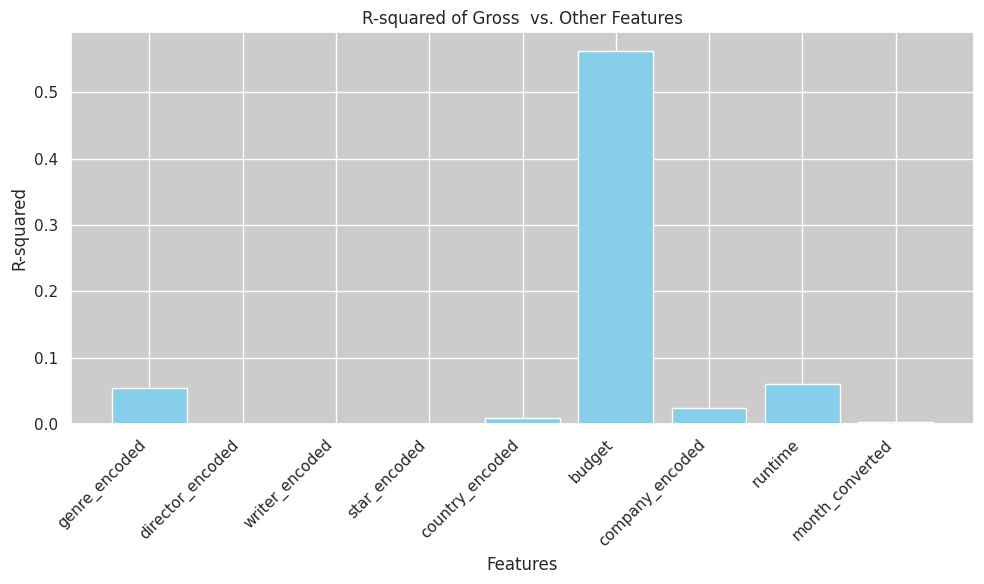

In [85]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt


# Select score as the independent variable
X = movies_metadata_df[['gross']]

# List of features to analyze (replace with your actual features)
features = ['genre_encoded', 'director_encoded',
       'writer_encoded', 'star_encoded', 'country_encoded', 'budget', 'company_encoded', 'runtime',
       'month_converted']  # Include 'gross' for comparison

# Create an empty list to store R-squared values
r_squared_values = []

# Loop through features
for feature in features:
  y = movies_metadata_df[feature]  # Assign each feature as the dependent variable

  # Rest of the code for model creation, fitting, R-squared calculation
  model = LinearRegression()
  model.fit(X, y)
  predicted_y = model.predict(X)
  r_squared = r2_score(y, predicted_y)
  r_squared_values.append(r_squared)  # Store R-squared for each feature

# Bar chart creation
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.bar(features, r_squared_values, color='skyblue')
plt.xlabel("Features")
plt.ylabel("R-squared")
plt.title("R-squared of Gross  vs. Other Features")
plt.xticks(rotation=45, ha='right')  # Rotate feature names for readability
plt.tight_layout()
plt.show()


In [86]:
from numpy import corrcoef
correlation = corrcoef(X.T)

# Print the correlation matrix (optional)
print("Correlation Matrix:")
print(correlation)

Correlation Matrix:
1.0


In [87]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Select score and gross columns
X = movies_metadata_df[['score']]  # Independent variable (score)
y = movies_metadata_df['gross']    # Dependent variable (gross)

# Create a linear regression model
model = LinearRegression()

# Fit the model to the data
model.fit(X, y)

# Make predictions (not needed for this analysis, but optional)
predicted_gross = model.predict(X)

# Get the coefficient of determination (R-squared)
r_squared = r2_score(y, predicted_gross)

# Get the p-value of the slope coefficient
p_value = model.coef_[0]  # Access the first coefficient (slope) p-value

# Print the results
print(f"R-squared: {r_squared:.4f}")
print(f"p-value of slope coefficient: {p_value:.4f}")
epsilon = 0.05
# Interpretation
if r_squared < epsilon and p_value > 0.05:
  print("This suggests score and gross might be independent variables.")
else:
  print("The results do not strongly support the independence of score and gross.")


R-squared: 0.0347
p-value of slope coefficient: 31300851.8428
This suggests score and gross might be independent variables.


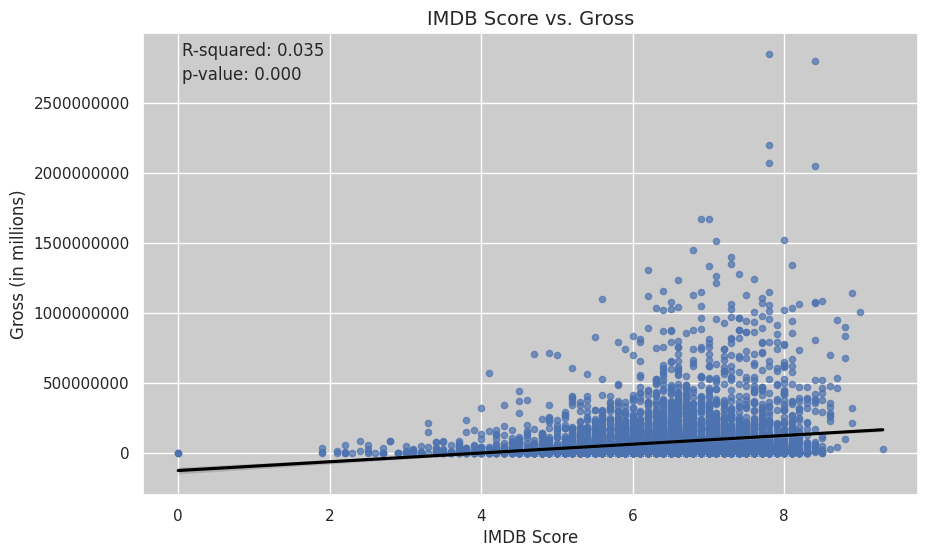

The results do not strongly support the independence of score and gross.


In [88]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Assuming movies_metadata_df is your DataFrame

# Optional: Filter to a specific time period (if needed)
# movies_metadata_df = movies_metadata_df[movies_metadata_df['year'] >= 1980]
# movies_metadata_df = movies_metadata_df[movies_metadata_df['year'] < 1990]

# Linear Regression
X = movies_metadata_df[['score']]
y = movies_metadata_df['gross']
model = LinearRegression().fit(X, y)
predicted_gross = model.predict(X)

# Calculate metrics
r_squared = r2_score(y, predicted_gross)
slope, intercept, r_value, p_value, std_err = stats.linregress(movies_metadata_df['score'], movies_metadata_df['gross'])

# Create scatter plot with seaborn
sns.set_theme(style="darkgrid", rc={"axes.facecolor": ".8"})
plt.figure(figsize=(10, 6))
sns.regplot(x='score', y='gross', data=movies_metadata_df,
            scatter_kws={'s': 20, 'alpha': 0.7}, line_kws={'color': 'black'})

# Add labels and title
plt.xlabel('IMDB Score', fontsize=12)
plt.ylabel('Gross (in millions)', fontsize=12)
plt.title('IMDB Score vs. Gross', fontsize=14)

# Optionally add text annotations for R-squared and p-value directly on the plot
plt.text(0.05, 0.95, f"R-squared: {r_squared:.3f}", transform=plt.gca().transAxes)
plt.text(0.05, 0.90, f"p-value: {p_value:.3f}", transform=plt.gca().transAxes)
plt.ticklabel_format(style='plain', axis='y')
# Show the plot
plt.show()

# Interpretation
if r_squared < epsilon and p_value > 0.05:
  print("This suggests score and gross might be independent variables.")
else:
  print("The results do not strongly support the independence of score and gross.")


# 3. Baseline Model Building

To start making predictions is common practice to start with a baseline model, the most classic model to this type of problem is a simple linear regression model. Before using the model, it is a good idea to do some feature engineering so we can use the categorical data.

## 3.1. Feature Engineering

To use the categorical columns, there must be done one-hot encoding (another option is doing target encoding, this would probably be better for "primary_production_company' because there are many different companies, and probably a best approach to language and country would be to classify between only two... US and other, because of the quantity of data for every other country being very low).

In [90]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split

**convert month to season**

In [91]:
def convert_month_to_season(month):
    if month in [1, 2, 3]:
        return 'Spring'
    elif month in [4, 5, 6]:
        return 'Summer'
    elif month in [7, 8, 9]:
        return 'Fall'
    else:
        return 'Winter'
movies_metadata_df['season'] = movies_metadata_df['month'].apply(convert_month_to_season)

<ipython-input-91-7bcdcb9d085c>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_metadata_df['season'] = movies_metadata_df['month'].apply(convert_month_to_season)


In [92]:
movies_metadata_df['season']

name
The Shining                                       Winter
The Blue Lagoon                                   Winter
Star Wars: Episode V - The Empire Strikes Back    Winter
Airplane!                                         Winter
Caddyshack                                        Winter
                                                   ...  
More to Life                                      Winter
Dream Round                                       Winter
Saving Mbango                                     Winter
It's Just Us                                      Winter
Tee em el                                         Winter
Name: season, Length: 7653, dtype: object

**Convert runtime to Short, Medium, Long**

In [93]:
def convert_runtime_to_bin(runtime):
    if runtime >= 0 and runtime < 90:
        return 'Short'
    elif runtime >= 90 and runtime < 120:
        return 'Medium'
    elif runtime >= 120:
        return 'Long'
movies_metadata_df['runtime_range'] = movies_metadata_df['runtime'].apply(convert_runtime_to_bin)

<ipython-input-93-0f40e2083876>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_metadata_df['runtime_range'] = movies_metadata_df['runtime'].apply(convert_runtime_to_bin)


In [94]:
movies_metadata_df['runtime_range']

name
The Shining                                         Long
The Blue Lagoon                                   Medium
Star Wars: Episode V - The Empire Strikes Back      Long
Airplane!                                          Short
Caddyshack                                        Medium
                                                   ...  
More to Life                                      Medium
Dream Round                                       Medium
Saving Mbango                                      Short
It's Just Us                                        Long
Tee em el                                         Medium
Name: runtime_range, Length: 7653, dtype: object

**Group rating to 5 main types: R, PG, G, PG-13, Unknown**

In [95]:
def combine_rating(rating):
    if rating in ["R", "NC-17", "TV-MA"]:
        return 'R'
    elif rating in ["G", "Approved"]:
        return 'G'
    elif rating in ["PG-13", "TV-14"]:
        return 'PG-13'
    elif rating in ["PG", "TV-PG"]:
        return 'PG'
    else:
      return 'Unkown'
movies_metadata_df['rating_converted'] = movies_metadata_df['rating'].apply(combine_rating)

<ipython-input-95-02bec88063cc>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_metadata_df['rating_converted'] = movies_metadata_df['rating'].apply(combine_rating)


In [96]:
movies_metadata_df['rating_converted'].unique()

array(['R', 'PG', 'G', 'Unkown', 'PG-13'], dtype=object)

In [97]:
movies_metadata_df['profit'] = movies_metadata_df['gross'] - movies_metadata_df['budget']

<ipython-input-97-7c75816242ab>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_metadata_df['profit'] = movies_metadata_df['gross'] - movies_metadata_df['budget']


**Combine score and profit to cluster directors**

In [98]:
# import pandas as pd

# # Assuming df is your original dataframe
# # and 'director', 'score', 'profit' are the column names

# # Group by director and calculate total score and profit
# grouped_df = movies_metadata_df.groupby('genre').agg({'score': 'mean', 'profit': 'mean'}).reset_index()


# # Rename the columns
# grouped_df.columns = ['genre', 'Total Score', 'Total Profit']

# # Display the new dataframe
# grouped_df.head(20)


In [99]:
# grouped_df.shape

In [100]:
# from sklearn.cluster import KMeans
# import matplotlib.pyplot as plt

# # Assuming grouped_df is your dataframe
# # and 'Total Score', 'Total Profit' are the column names

# # Prepare data for clustering
# X = grouped_df[['Total Score', 'Total Profit']]

# # Create a KMeans object
# kmeans = KMeans(n_clusters=3)  # You can change the number of clusters

# # Fit the data
# kmeans.fit(X)

# # Get the cluster labels
# labels = kmeans.labels_

# # Add the cluster labels to the dataframe
# grouped_df['Cluster'] = labels

# # Plot the clusters
# plt.scatter(grouped_df['Total Score'], grouped_df['Total Profit'], c=grouped_df['Cluster'])
# plt.xlabel('Total Score')
# plt.ylabel('Total Profit')
# plt.title('Company Clustering')
# plt.show()


In [101]:
# # Create a dictionary from the new dataframe
# director_to_label = dict(zip(grouped_df['genre'], grouped_df['Cluster']))

# # Map the labels to the original dataframe
# movies_metadata_df['genre_score'] = movies_metadata_df['genre'].map(director_to_label)


In [102]:
# movies_metadata_df.head(50)

**Convert director to best_director**

In [103]:
%cd /content/drive/MyDrive/Khai thác dữ liệu và ứng dụng - T5/Final_dataset/MoviesIndustry

/content/drive/.shortcut-targets-by-id/1OHx_dSVczxKZiq3Yvpt6dWJb0csHFdF4/Khai thác dữ liệu và ứng dụng - T5/Final_dataset/MoviesIndustry


In [104]:
# movies_metadata_df['weight_director'] = 0
# for i, row in movies_metadata_df.iterrows():
#     print(i)
#     # print(row)
#     company = row['director']
#     profit = row['gross'] - row['budget']

#     # Calculate average profit
#     company_df = movies_metadata_df[movies_metadata_df['director'] == company]
#     print(company_df,company)
#     # print(company_df, len(company_df))
#     break
#     if len(company_df) > 4:  # Threshold of at least 5 movies
#         average_profit = company_df['gross'].sub(company_df['budget']).mean()

#         # Compare movie's profit to average
#         if profit > average_profit:
#             movies_metadata_df.at[i, 'weight_director'] = 5
#         elif profit == average_profit:
#             movies_metadata_df.at[i, 'weight_director'] = 3
#         else:
#             movies_metadata_df.at[i, 'weight_director'] = 1
#     else:
#       print("something weird")

In [105]:
import pandas as pd

# Assuming df is your DataFrame, 'revenue' and 'budget' are the columns with the revenue and budget values, and 'company' is the column with the company names
# Calculate the profit for each row


# Calculate the total profit for each company
total_profit = movies_metadata_df.groupby('director')['profit'].sum()

# Calculate the mean profit of the whole dataset
mean_profit = movies_metadata_df['profit'].mean()

# Create a new column 'company_score'
movies_metadata_df['director_score'] = movies_metadata_df['director'].map(total_profit)

# Set the values based on the condition
movies_metadata_df['director_score'] = movies_metadata_df['director_score'].apply(lambda x: 5 if x > mean_profit else (3 if x == mean_profit else (1 if x > 0 and x < mean_profit else 0)))


<ipython-input-105-38adb1bdd1cf>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_metadata_df['director_score'] = movies_metadata_df['director'].map(total_profit)
<ipython-input-105-38adb1bdd1cf>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_metadata_df['director_score'] = movies_metadata_df['director_score'].apply(lambda x: 5 if x > mean_profit else (3 if x == mean_profit else (1 if x > 0 and x < mean_profit else 0)))


In [106]:
movies_metadata_df['director_score'].unique()

array([5, 1, 0])

In [107]:
# Create a new DataFrame with unique 'company' and 'company_score' rows
unique_company_df = movies_metadata_df[['director', 'director_score']].drop_duplicates()
print(unique_company_df.shape)

# Save the DataFrame to a CSV file
unique_company_df.to_csv('director.csv', index=False)

(2943, 2)


In [108]:
import pandas as pd

# Assuming df is your DataFrame, 'revenue' and 'budget' are the columns with the revenue and budget values, and 'company' is the column with the company names
# Calculate the profit for each row
movies_metadata_df['profit'] = movies_metadata_df['gross'] - movies_metadata_df['budget']

# Calculate the total profit for each company
total_profit = movies_metadata_df.groupby('company')['profit'].sum()

# Calculate the mean profit of the whole dataset
mean_profit = movies_metadata_df['profit'].mean()

# Create a new column 'company_score'
movies_metadata_df['company_score'] = movies_metadata_df['company'].map(total_profit)

# Set the values based on the condition
movies_metadata_df['company_score'] = movies_metadata_df['company_score'].apply(lambda x: 5 if x > mean_profit else (3 if x == mean_profit else (1 if x > 0 and x < mean_profit else 0)))


<ipython-input-108-52c0c9a487ba>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_metadata_df['profit'] = movies_metadata_df['gross'] - movies_metadata_df['budget']
<ipython-input-108-52c0c9a487ba>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_metadata_df['company_score'] = movies_metadata_df['company'].map(total_profit)
<ipython-input-108-52c0c9a487ba>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

In [109]:
# Create a new DataFrame with unique 'company' and 'company_score' rows
unique_company_df = movies_metadata_df[['company', 'company_score']].drop_duplicates()
print(unique_company_df.shape)

# Save the DataFrame to a CSV file
unique_company_df.to_csv('company.csv', index=False)

(2376, 2)


In [110]:
import pandas as pd

# Assuming df is your DataFrame, 'revenue' and 'budget' are the columns with the revenue and budget values, and 'genre' is the column with the genre names
# Calculate the profit for each row
movies_metadata_df['profit'] = movies_metadata_df['gross'] - movies_metadata_df['budget']

# Calculate the total profit for each company
total_profit = movies_metadata_df.groupby('genre')['profit'].sum()

# Calculate the mean profit of the whole dataset
mean_profit = movies_metadata_df['profit'].mean()

# Create a new column 'company_score'
movies_metadata_df['genre_score'] = movies_metadata_df['genre'].map(total_profit)

# Set the values based on the condition
movies_metadata_df['genre_score'] = movies_metadata_df['genre_score'].apply(lambda x: 5 if x > mean_profit else (3 if x == mean_profit else (1 if x > 0 and x < mean_profit else 0)))


<ipython-input-110-3772bd47b1fe>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_metadata_df['profit'] = movies_metadata_df['gross'] - movies_metadata_df['budget']
<ipython-input-110-3772bd47b1fe>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_metadata_df['genre_score'] = movies_metadata_df['genre'].map(total_profit)
<ipython-input-110-3772bd47b1fe>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

In [111]:
# Create a new DataFrame with unique 'company' and 'company_score' rows
unique_company_df = movies_metadata_df[['genre', 'genre_score']].drop_duplicates()
print(unique_company_df.shape)

# Save the DataFrame to a CSV file
unique_company_df.to_csv('genre.csv', index=False)

(19, 2)


In [112]:
import pandas as pd

# Assuming df is your DataFrame, 'revenue' and 'budget' are the columns with the revenue and budget values, and 'genre' is the column with the genre names
# Calculate the profit for each row
movies_metadata_df['profit'] = movies_metadata_df['gross'] - movies_metadata_df['budget']

# Calculate the total profit for each company
total_profit = movies_metadata_df.groupby('star')['profit'].sum()

# Calculate the mean profit of the whole dataset
mean_profit = movies_metadata_df['profit'].mean()

# Create a new column 'company_score'
movies_metadata_df['star_score'] = movies_metadata_df['star'].map(total_profit)

# Set the values based on the condition
movies_metadata_df['star_score'] = movies_metadata_df['star_score'].apply(lambda x: 5 if x > mean_profit else (3 if x == mean_profit else (1 if x > 0 and x < mean_profit else 0)))


<ipython-input-112-4888610a3342>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_metadata_df['profit'] = movies_metadata_df['gross'] - movies_metadata_df['budget']
<ipython-input-112-4888610a3342>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_metadata_df['star_score'] = movies_metadata_df['star'].map(total_profit)
<ipython-input-112-4888610a3342>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

In [113]:
# Create a new DataFrame with unique 'company' and 'company_score' rows
unique_company_df = movies_metadata_df[['star', 'star_score']].drop_duplicates()
print(unique_company_df.shape)

# Save the DataFrame to a CSV file
unique_company_df.to_csv('star.csv', index=False)

(2808, 2)


In [114]:
import pandas as pd

# Assuming df is your DataFrame, 'revenue' and 'budget' are the columns with the revenue and budget values, and 'genre' is the column with the genre names
# Calculate the profit for each row
movies_metadata_df['profit'] = movies_metadata_df['gross'] - movies_metadata_df['budget']

# Calculate the total profit for each company
total_profit = movies_metadata_df.groupby('writer')['profit'].sum()

# Calculate the mean profit of the whole dataset
mean_profit = movies_metadata_df['profit'].mean()

# Create a new column 'company_score'
movies_metadata_df['writer_score'] = movies_metadata_df['writer'].map(total_profit)

# Set the values based on the condition
movies_metadata_df['writer_score'] = movies_metadata_df['writer_score'].apply(lambda x: 5 if x > mean_profit else (3 if x == mean_profit else (1 if x > 0 and x < mean_profit else 0)))


<ipython-input-114-9b298139bf07>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_metadata_df['profit'] = movies_metadata_df['gross'] - movies_metadata_df['budget']
<ipython-input-114-9b298139bf07>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_metadata_df['writer_score'] = movies_metadata_df['writer'].map(total_profit)
<ipython-input-114-9b298139bf07>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

In [115]:
# Create a new DataFrame with unique 'company' and 'company_score' rows
unique_company_df = movies_metadata_df[['writer', 'writer_score']].drop_duplicates()
print(unique_company_df.shape)

# Save the DataFrame to a CSV file
unique_company_df.to_csv('writer.csv', index=False)

(4530, 2)


## 3.2. Creating the Model

As mentioned before, the chosen model for the baseline will be the classic Linear Regression, next are the train/test split, model building, predicting using the model, and model evaluation.

### 3.2.1 Decision Tree

In [116]:
movies_metadata_df.columns

Index(['rating', 'genre', 'year', 'released', 'score', 'votes', 'director',
       'writer', 'star', 'country', 'budget', 'gross', 'company', 'runtime',
       'month', 'successful', 'condition_1', 'genre_encoded',
       'company_encoded', 'director_encoded', 'writer_encoded', 'star_encoded',
       'country_encoded', 'month_converted', 'season', 'runtime_range',
       'rating_converted', 'profit', 'director_score', 'company_score',
       'genre_score', 'star_score', 'writer_score'],
      dtype='object')

In [117]:
from sklearn.preprocessing import LabelEncoder

# Assuming df is your DataFrame and 'category' is the column with categorical data
le = LabelEncoder()
movies_metadata_df['director'] = le.fit_transform(movies_metadata_df['director'])
movies_metadata_df['genre'] = le.fit_transform(movies_metadata_df['genre'])
movies_metadata_df['company'] = le.fit_transform(movies_metadata_df['company'])
movies_metadata_df['star'] = le.fit_transform(movies_metadata_df['star'])
movies_metadata_df['writer'] = le.fit_transform(movies_metadata_df['writer'])
movies_metadata_df['country'] = le.fit_transform(movies_metadata_df['country'])
movies_metadata_df['rating'] = le.fit_transform(movies_metadata_df['rating'])
movies_metadata_df['released'] = le.fit_transform(movies_metadata_df['released'])
movies_metadata_df['rating'] = le.fit_transform(movies_metadata_df['rating'])
movies_metadata_df['season'] = le.fit_transform(movies_metadata_df['season'])

<ipython-input-117-b8d13c673e08>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_metadata_df['director'] = le.fit_transform(movies_metadata_df['director'])
<ipython-input-117-b8d13c673e08>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_metadata_df['genre'] = le.fit_transform(movies_metadata_df['genre'])
<ipython-input-117-b8d13c673e08>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

In [118]:
movies_metadata_df['rating_converted'] = le.fit_transform(movies_metadata_df['rating_converted'])

<ipython-input-118-46b0a409c3c9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_metadata_df['rating_converted'] = le.fit_transform(movies_metadata_df['rating_converted'])


In [119]:
unknown_count = movies_metadata_df['month'].value_counts().get('Unknown', 0)
print(f"Number of 'Unknown' month values: {unknown_count}")

Number of 'Unknown' month values: 0


In [120]:
movies_metadata_df = movies_metadata_df[movies_metadata_df['month'] != 'Unknown']

In [121]:
month_map = {'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6, 'July': 7,'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12}

# Replace month names with corresponding numbers
movies_metadata_df['month_converted'] = movies_metadata_df['month'].replace(month_map)

In [122]:
movies_metadata_df.columns

Index(['rating', 'genre', 'year', 'released', 'score', 'votes', 'director',
       'writer', 'star', 'country', 'budget', 'gross', 'company', 'runtime',
       'month', 'successful', 'condition_1', 'genre_encoded',
       'company_encoded', 'director_encoded', 'writer_encoded', 'star_encoded',
       'country_encoded', 'month_converted', 'season', 'runtime_range',
       'rating_converted', 'profit', 'director_score', 'company_score',
       'genre_score', 'star_score', 'writer_score'],
      dtype='object')

**Decision Tree without Data Insight**

In [123]:
# Split the data into training and testing sets

X = movies_metadata_df[['rating', 'genre','year', 'released',  'writer', 'star', 'country', 'budget', 'company', 'runtime']]
y = movies_metadata_df['successful']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [124]:
# finding best parameter for Decision Tree
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

import numpy as np
param_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced', None],
    'random_state': [42]
}

grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5, scoring='neg_mean_absolute_error')
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best parameters:", best_params)

y_pred = best_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print("Mean absolute error:", mae)

# Convert the predictions to binary values (0 or 1)
y_pred_binary = np.where(y_pred > 0.5, 1, 0)

# Calculate accuracy
accuracy = np.mean(y_pred_binary == y_test)
print("Accuracy:", accuracy)


Best parameters: {'class_weight': None, 'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'random_state': 42, 'splitter': 'best'}
Mean absolute error: 0.27433050293925537
Accuracy: 0.7256694970607446


In [125]:
# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

print('Confusion Matrix :')
print(cm)

# Print the classification report
print('\nClassification Report :')
print(classification_report(y_test, y_pred_binary))

Confusion Matrix :
[[372 202]
 [218 739]]

Classification Report :
              precision    recall  f1-score   support

           0       0.63      0.65      0.64       574
           1       0.79      0.77      0.78       957

    accuracy                           0.73      1531
   macro avg       0.71      0.71      0.71      1531
weighted avg       0.73      0.73      0.73      1531



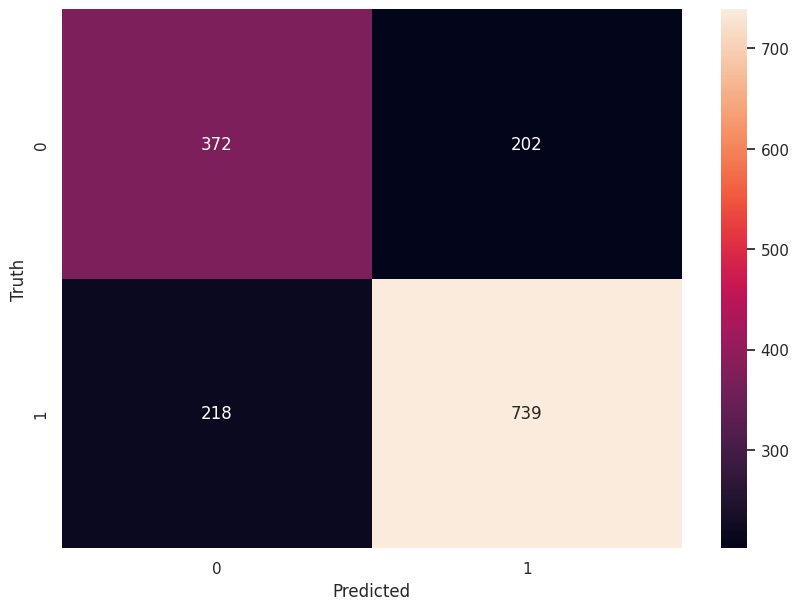

In [126]:
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.savefig('confusion_matrix.png')
plt.show()

**Pre-prunning with data insights**

In [127]:
X = movies_metadata_df[['budget', 'runtime','rating_converted', 'director_score',  'company_score','genre_score', 'star_score', 'writer_score', 'month_converted']]
y = movies_metadata_df['successful']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [128]:
movies_metadata_df.head(10)

rating  genre  year  released  \
name                                                                            
The Shining                                          6      6  1980      1695   
The Blue Lagoon                                      6      1  1980      1482   
Star Wars: Episode V - The Empire Strikes Back       4      0  1980      1761   
Airplane!                                            4      4  1980      1482   
Caddyshack                                           6      4  1980      1533   
Friday the 13th                                      6     10  1980      2492   
The Blues Brothers                                   6      0  1980      1761   
Raging Bull                                          6      3  1980       689   
Superman II                                          4      0  1980      1743   
The Long Riders                                      6      3  1980      2276   

                                                score      votes  director  \
name                                                                         
The Shining                                       8.4   927000.0      2583   
The Blue Lagoon                                   5.8    65000.0      2263   
Star Wars: Episode V - The Empire Strikes Back    8.7  1200000.0      1107   
Airplane!                                         7.7   221000.0      1296   
Caddyshack                                        7.3   108000.0      1050   
Friday the 13th                                   6.4   123000.0      2522   
The Blues Brothers                                7.9   188000.0      1407   
Raging Bull                                       8.2   330000.0      1823   
Superman II                                       6.8   101000.0      2300   
The Long Riders                                   7.0    10000.0      2858   

                                                writer  star  country  ...  \
name                                                                   ...   
The Shining                                       4010  1043       54  ...   
The Blue Lagoon                                   1629   325       55  ...   
Star Wars: Episode V - The Empire Strikes Back    2564  1740       55  ...   
Airplane!                                         1997  2239       55  ...   
Caddyshack                                         519   408       55  ...   
Friday the 13th                                   4358   239       55  ...   
The Blues Brothers                                 836  1273       55  ...   
Raging Bull                                       1766  2233       55  ...   
Superman II                                       1976   873       55  ...   
The Long Riders                                    421   585       55  ...   

                                                month_converted  season  \
name                                                                      
The Shining                                                   6       0   
The Blue Lagoon                                               7       0   
Star Wars: Episode V - The Empire Strikes Back                6       0   
Airplane!                                                     7       0   
Caddyshack                                                    7       0   
Friday the 13th                                               5       0   
The Blues Brothers                                            6       0   
Raging Bull                                                  12       0   
Superman II                                                   6       0   
The Long Riders                                               5       0   

                                                runtime_range  \
name                                                            
The Shining                                              Long   
The Blue Lagoon                                        Medium   
Star Wars: Episode V - The Empire Strike

In [129]:
# finding best parameter for Decision Tree
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

import numpy as np
param_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced', None],
    'random_state': [42]
}

grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5, scoring='neg_mean_absolute_error')
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best parameters:", best_params)

y_pred = best_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print("Mean absolute error:", mae)

# Convert the predictions to binary values (0 or 1)
y_pred_binary = np.where(y_pred > 0.5, 1, 0)

# Calculate accuracy
accuracy = np.mean(y_pred_binary == y_test)
print("Accuracy:", accuracy)


Best parameters: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'random_state': 42, 'splitter': 'best'}
Mean absolute error: 0.1404310907903331
Accuracy: 0.8595689092096669


In [130]:
# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

print('Confusion Matrix :')
print(cm)

# Print the classification report
print('\nClassification Report :')
print(classification_report(y_test, y_pred_binary))

Confusion Matrix :
[[456 118]
 [ 97 860]]

Classification Report :
              precision    recall  f1-score   support

           0       0.82      0.79      0.81       574
           1       0.88      0.90      0.89       957

    accuracy                           0.86      1531
   macro avg       0.85      0.85      0.85      1531
weighted avg       0.86      0.86      0.86      1531



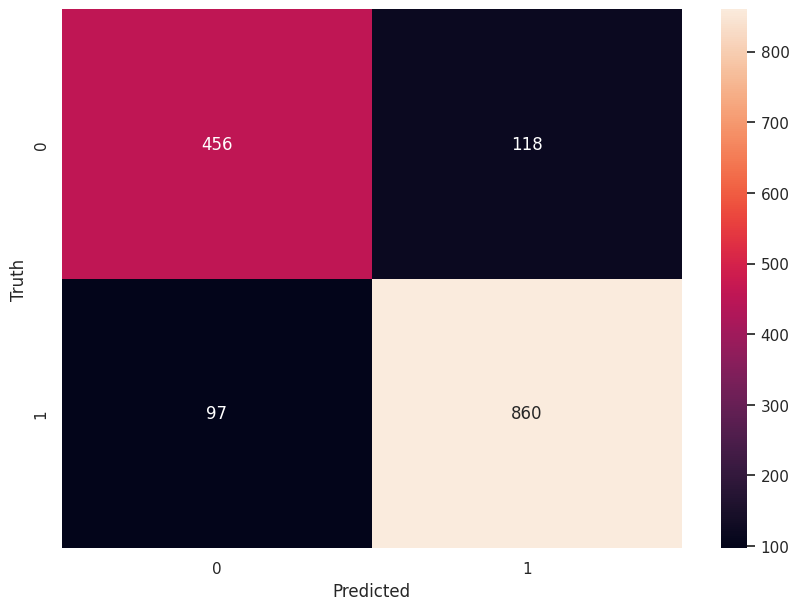

In [131]:
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.savefig('confusion_matrix.png')
plt.show()

**PostPruning**

In [132]:
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state=42)
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

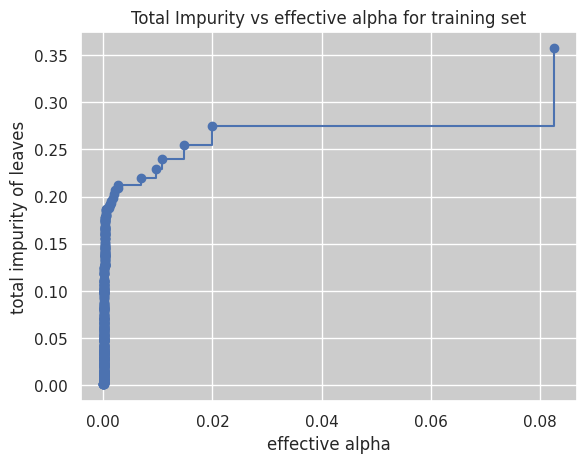

In [133]:
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

In [134]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)
print(
    "Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
        clfs[-1].tree_.node_count, ccp_alphas[-1]
    )
)

Number of nodes in the last tree is: 1 with ccp_alpha: 0.11569130770977226


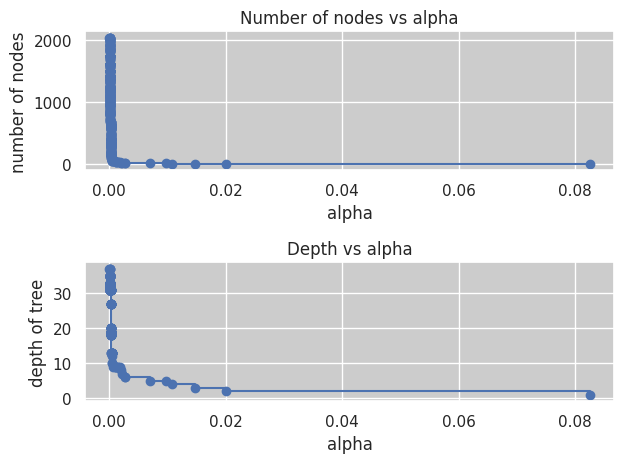

In [135]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()


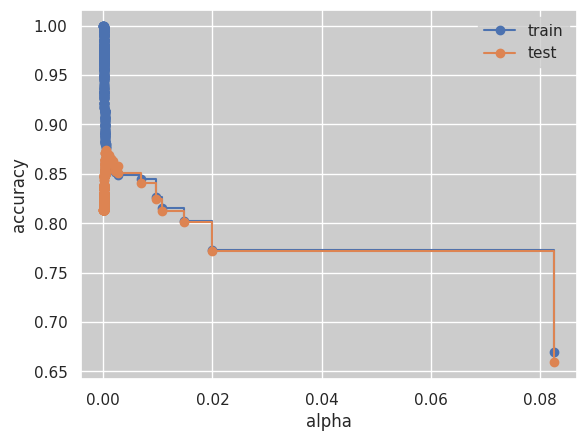

In [136]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
# ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

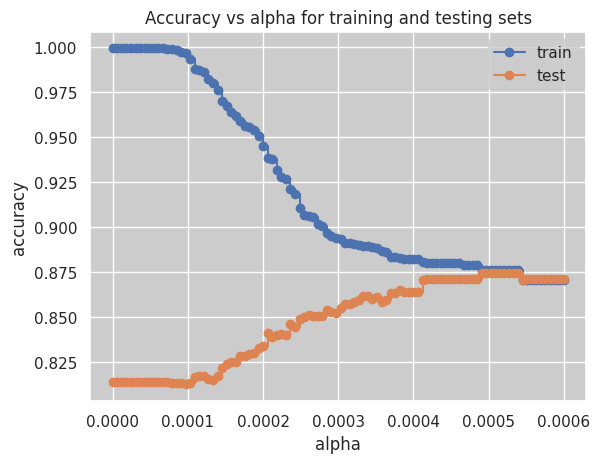

In [137]:
import numpy as np

# Assuming your current range of ccp_alphas is from min_alpha to max_alpha
min_alpha = min(ccp_alphas)
max_alpha = 0.0006

# Create a more finely spaced range of alphas
fine_ccp_alphas = np.linspace(min_alpha, max_alpha, num=100)  # Change num to the number of bins you want

# Now you need to retrain your models with these new alphas and get the scores
fine_clfs = [DecisionTreeClassifier(random_state=0, ccp_alpha=alpha).fit(X_train, y_train) for alpha in fine_ccp_alphas]
fine_train_scores = [clf.score(X_train, y_train) for clf in fine_clfs]
fine_test_scores = [clf.score(X_test, y_test) for clf in fine_clfs]

# And plot the results
fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(fine_ccp_alphas, fine_train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(fine_ccp_alphas, fine_test_scores, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

In [138]:
from sklearn.metrics import accuracy_score

model = DecisionTreeClassifier(ccp_alpha=0.00056
                               )

model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate and print the accuracy
accuracy = accuracy_score(y_test, y_pred)
rounded_accuracy = round(accuracy, 2)
# print(f'Accuracy: {rounded_accuracy:.2f}')
print(accuracy)

0.8713259307642064


In [139]:
# Print the parameters
print(f"class_weight: {model.class_weight}")
print(f"criterion: {model.criterion}")
print(f"max_depth: {model.max_depth}")
print(f"min_samples_leaf: {model.min_samples_leaf}")
print(f"min_samples_split: {model.min_samples_split}")
print(f"random_state: {model.random_state}")
print(f"splitter: {model.splitter}")

class_weight: None
criterion: gini
max_depth: None
min_samples_leaf: 1
min_samples_split: 2
random_state: None
splitter: best


In [140]:
# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

print('Confusion Matrix :')
print(cm)

# Print the classification report
print('\nClassification Report :')
print(classification_report(y_test, y_pred))

Confusion Matrix :
[[418 156]
 [ 41 916]]

Classification Report :
              precision    recall  f1-score   support

           0       0.91      0.73      0.81       574
           1       0.85      0.96      0.90       957

    accuracy                           0.87      1531
   macro avg       0.88      0.84      0.86      1531
weighted avg       0.88      0.87      0.87      1531



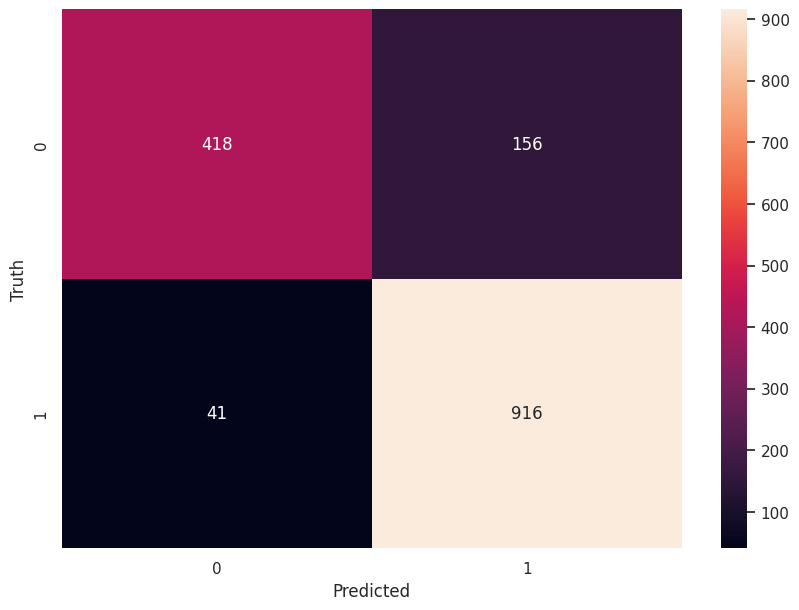

In [141]:
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.savefig('confusion_matrix.png')
plt.show()

In [142]:
mae = mean_absolute_error(y_test, y_pred)
print("Mean absolute error:", mae)

Mean absolute error: 0.1286740692357936


**Tree**

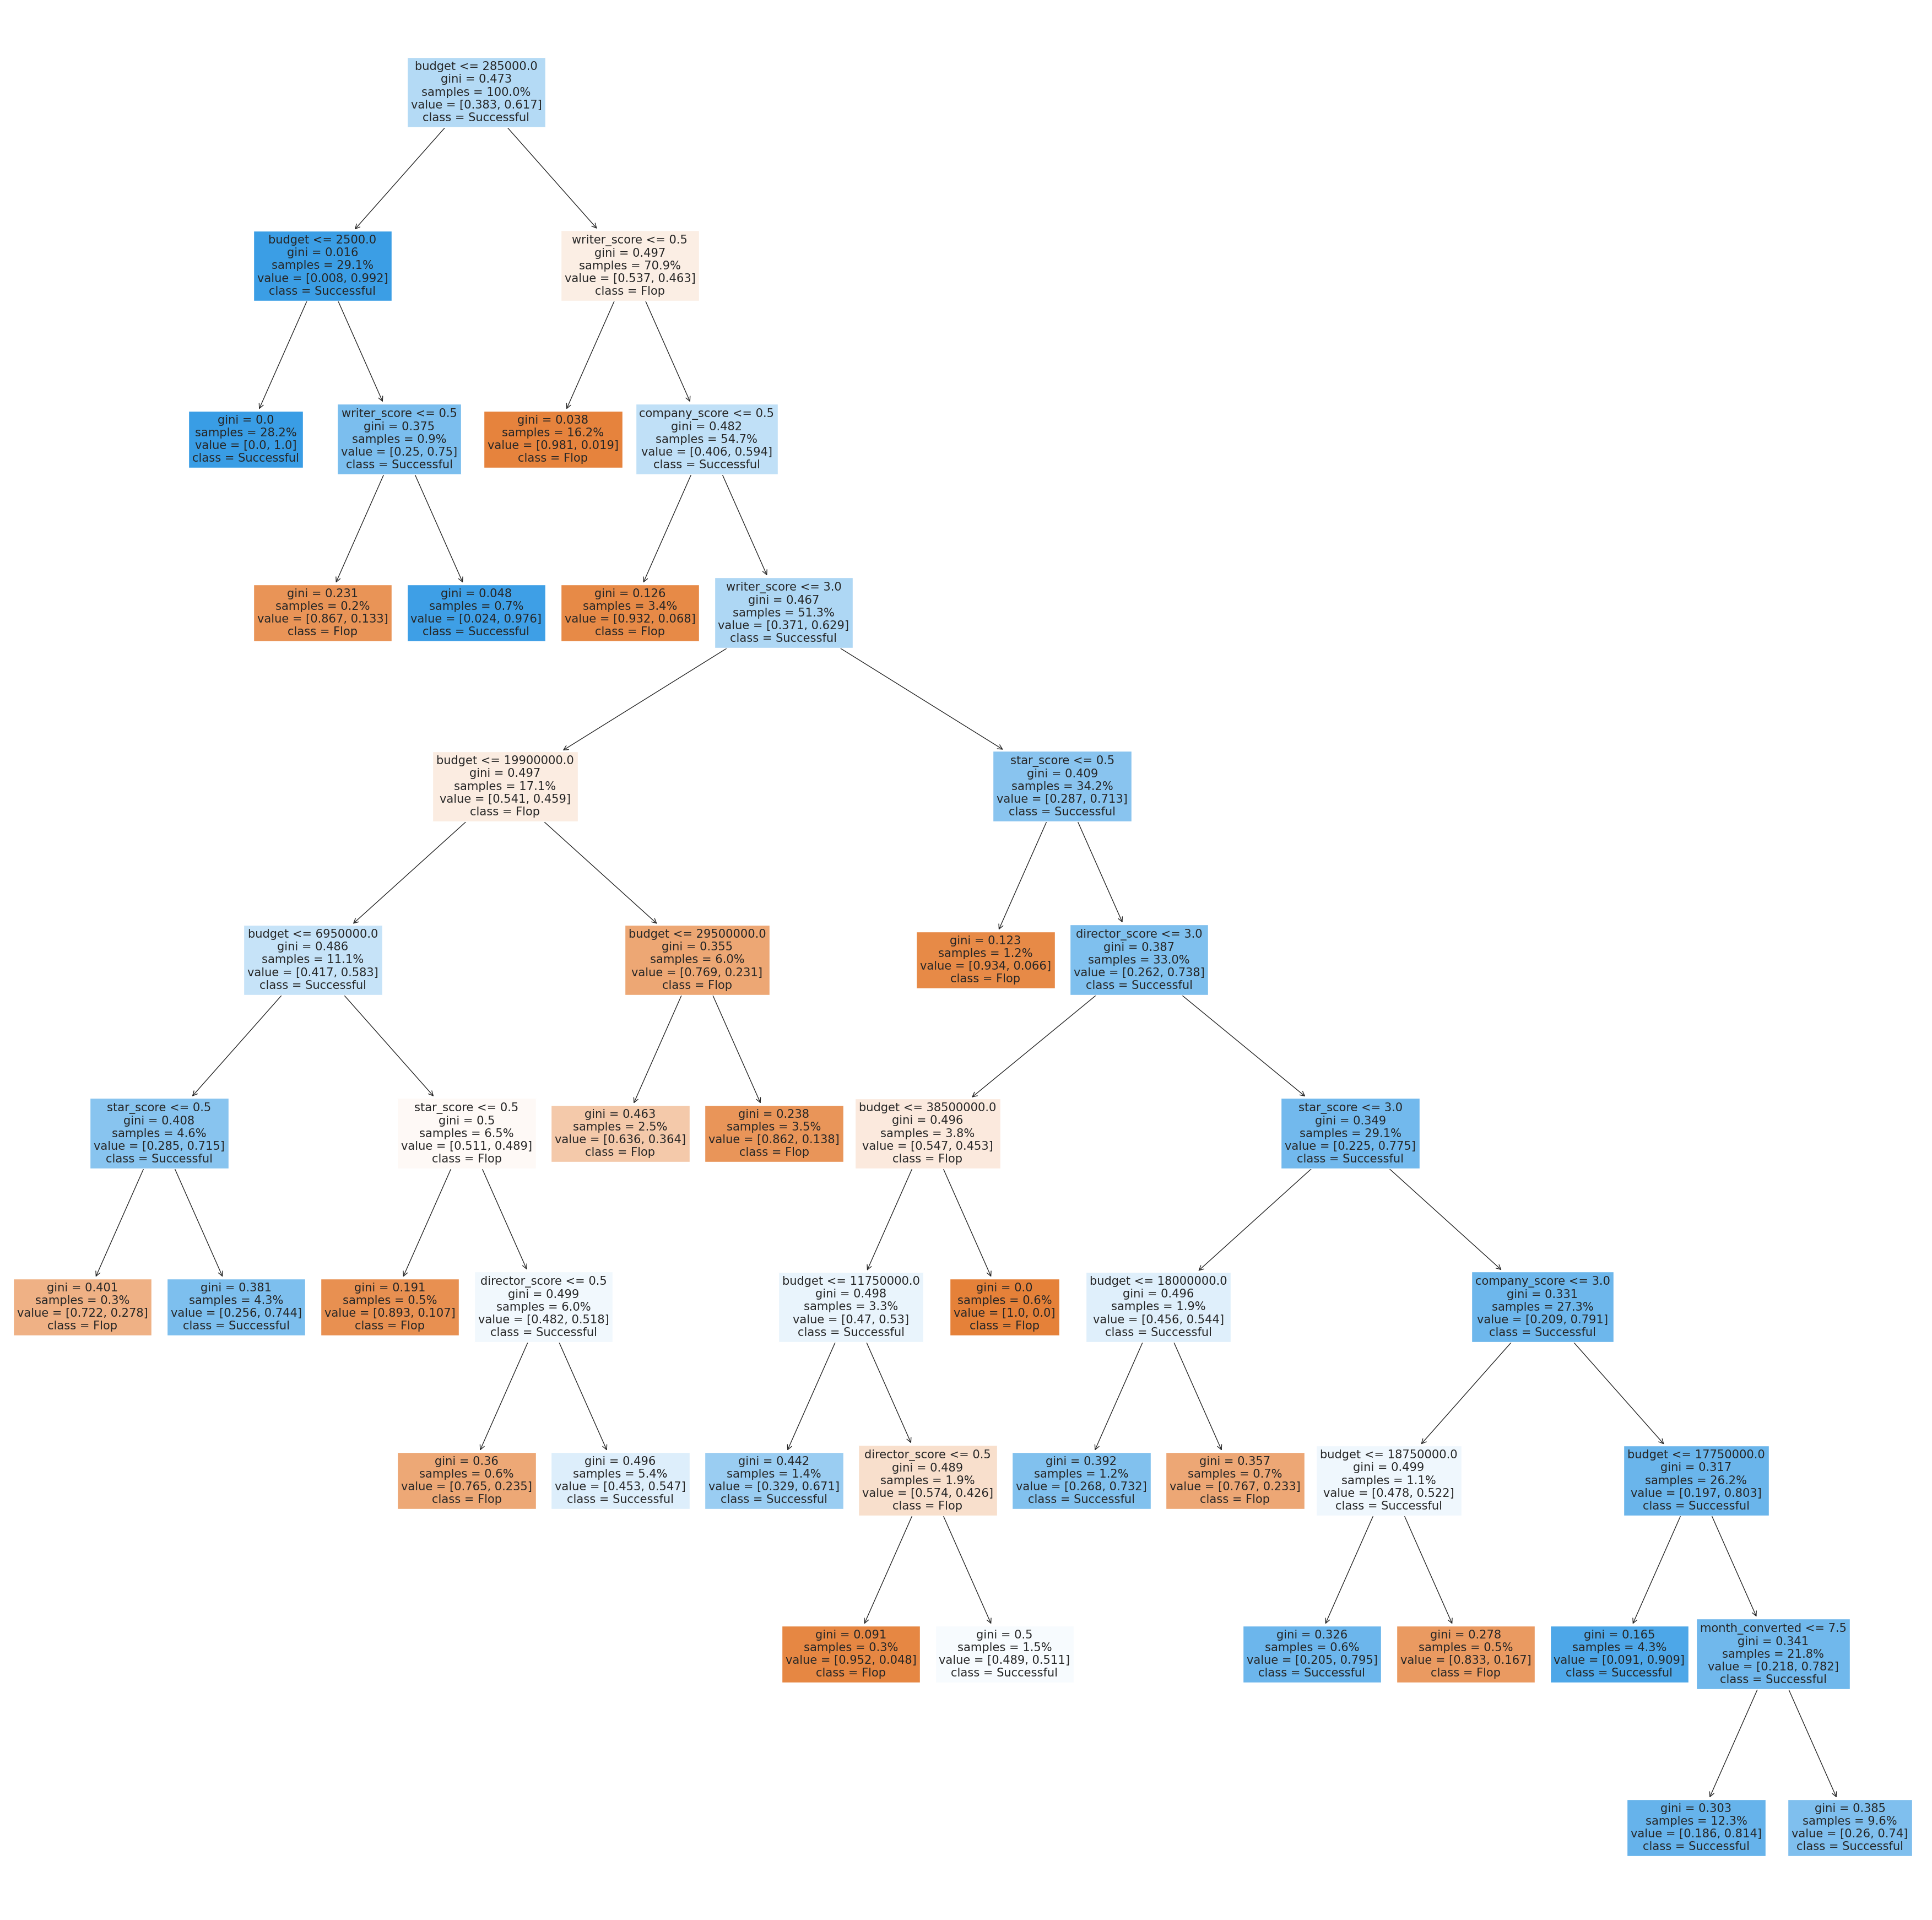

In [143]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Assuming clf is your trained Decision Tree model
plt.figure(figsize=(45, 45))
plot_tree(model, filled=True, feature_names=X_train.columns, class_names=['Flop', 'Successful'], proportion=True)
plt.savefig('decision_tree.png')
plt.show()
